# Prediction of ecological function in the microbiome using machine learning on the graph spectra of co-diversifying subnetworks

## The search for allopatric speciation in the gut microbial communities of Tanganyikan cichlids

##### An adventure in fish poo.

*Russell Neches*

In [190]:
%pylab inline
#%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Meet the specimens

Let's have look at the 14 fish used in this study. First of all,
let's see what they actually look like. With the exception of 
_Xenotilapia_, _Plecodus_ and _Tanganicodus_, all these photos
are of the actual individuals used in the study.

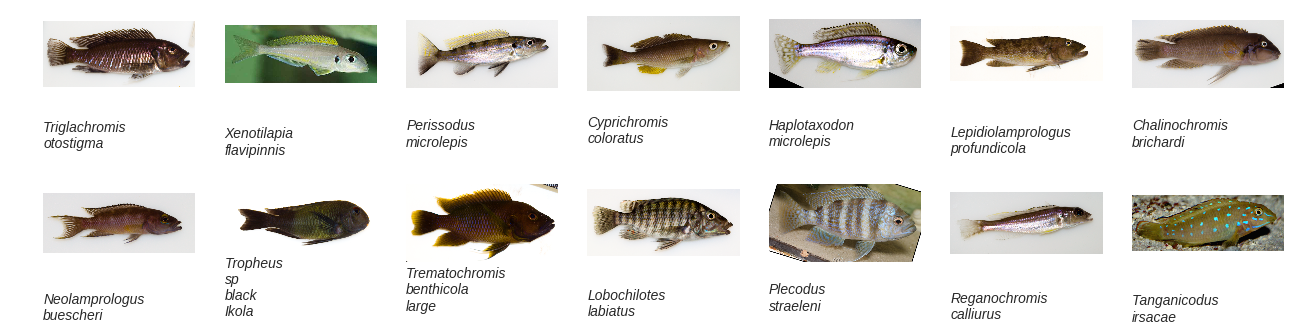

In [191]:
from IPython.display import display, Image
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(16, 4))

for root, _, files in os.walk('host_phenotypes') :
    for n,file in enumerate(files) :
        i =  mpimg.imread('host_phenotypes/' + file )
        subplot(2,7,n+1)
        plt.imshow(i)
        text( 0, 500, file.replace('_','\n').replace('.png',''), style='italic' )
        plt.axis('off')

Now, let's look at the host phylogeny. I've taken a subset of a much larger tree
assembled by Matt McGee. The paper should be bioarXiv by the time this is published,
and I will add a reference.

In [7]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
#ts.mode = 'c'
ts.show_leaf_name = True
ts.branch_vertical_margin = 1
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0
nstyle["vt_line_width"] = 1
nstyle["hz_line_width"] = 1
nstyle["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
nstyle["hz_line_type"] = 0

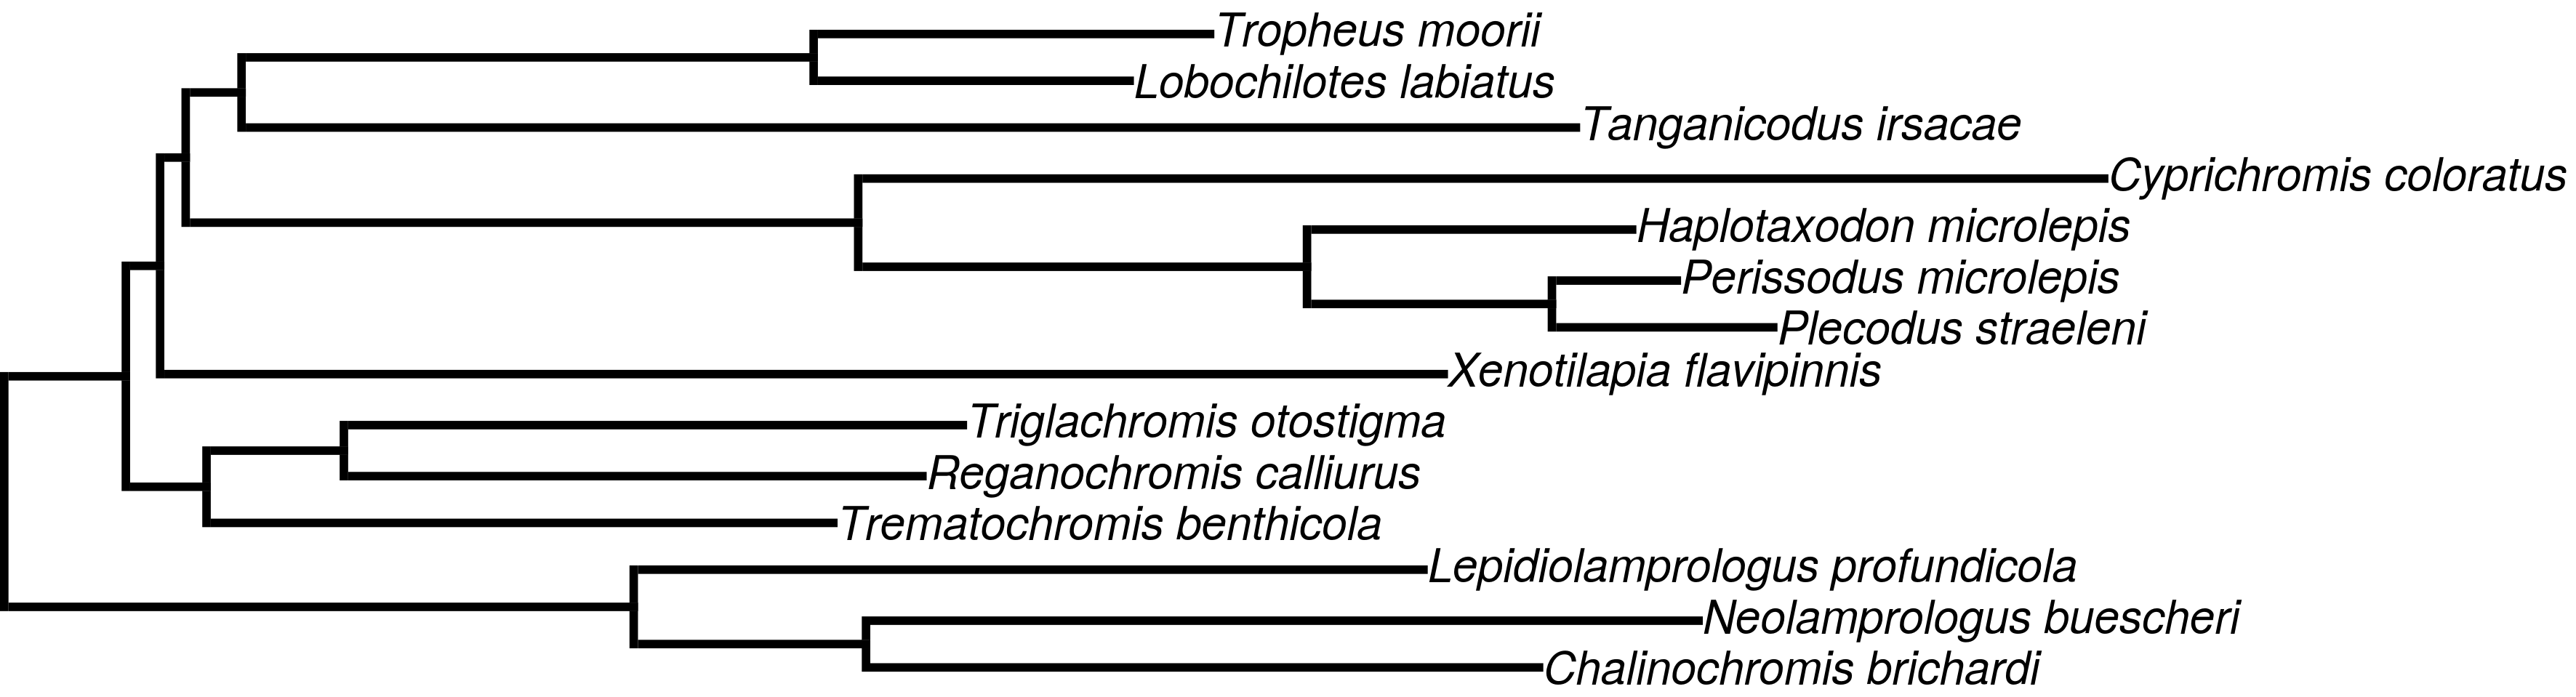

In [8]:
tree = Tree('host_tree/mcgeetree/mcgee_trimmed.tree')

for node in tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 2
        tf.ftype = 'TeX Gyre Heros'
        tf.hz_align = 0
        tf.fstyle = 'italic'
        tf.tight_text = True
        node.add_face( tf, 0 )

tree.render("%%inline", w=1000, units="mm", tree_style=ts)

In [64]:
tree.render("mcgee_tree.pdf", w=1000, units="mm", tree_style=ts)
del(tree)

## Meet the microbes

Now, let's have a look at the microbes we found in this study. Or, at their
phylogeny, anyway.

This tree was built using `FastTree` from unique sequences identified using our
`Shand` pipeline.

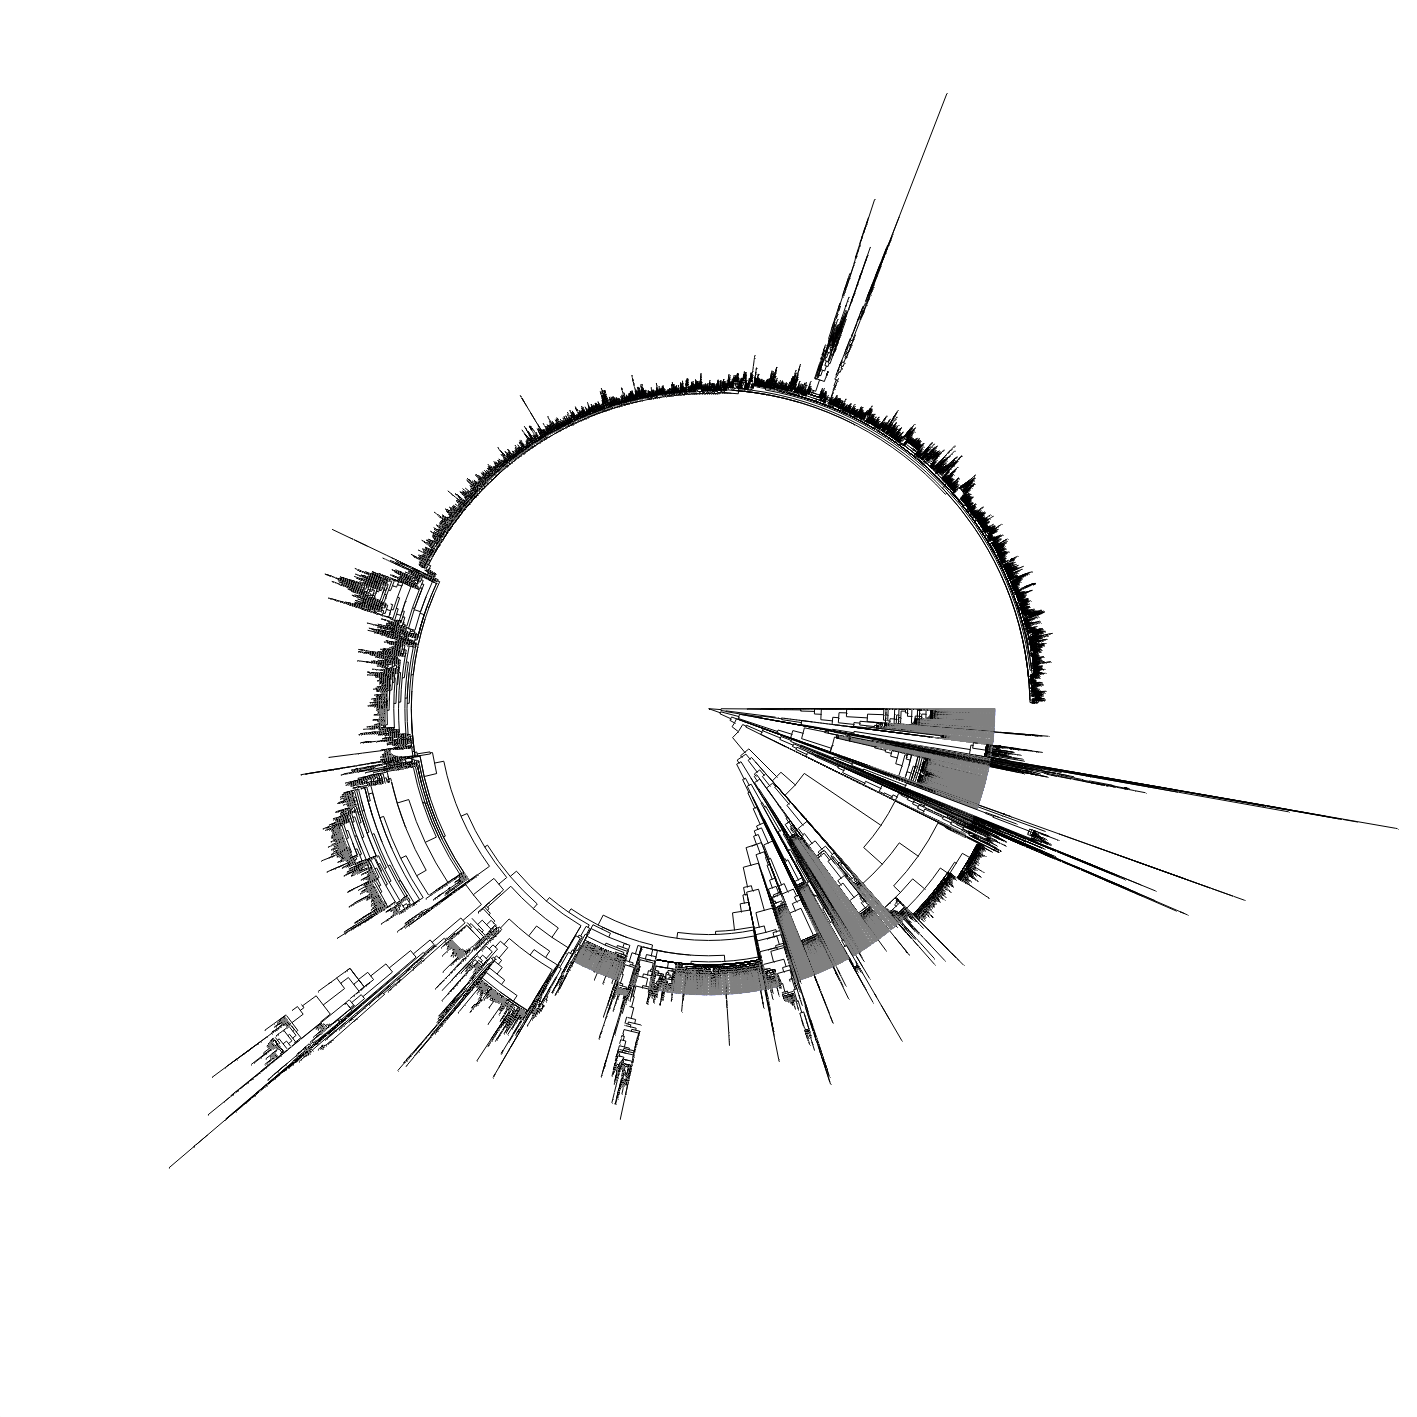

In [58]:
ts = TreeStyle()
ts.mode = 'c'
ts.show_leaf_name = False
ts.branch_vertical_margin = 30
ts.scale = 1000000

t = Tree('dissertation_run_unique_2_clustalo_fasttree.tree')
t.set_outgroup( t.get_midpoint_outgroup() ) # balance the unrooted tree
        
t.render("%%inline", w=400, units="mm", tree_style=ts)

In [65]:
t.render("fishpoo_tree.png", w=2000, units="mm", tree_style=ts)
del(t)

## Phylogenetic signal

Now, we'll look at how the microbes are distributed over the host tree if we
treat their presence or absence as host traits. For this, we'll need to use some
functions from `R` packages, which shall require some unpleasantness.

It doesn't make any sense to include samples that don't belong in the host tree
(i.e., our controls), so we'll drop those for now.

In [9]:
import pandas as pd

df = pd.read_csv( 'dissertation_run_host_abundance_table.tsv', sep='\t', index_col=0 )

# We're going to use this as a trait tabel, so we need to drop 
# non-host control samples 
df = df.drop( ['Water control', 'Charcoal control', 'Food', 'Kit control'] )
df = df.loc[:, (df != 0).any(axis=0)]
df.index = [ i.replace(' ','_') for i in df.index ]
df.to_csv( 'dissertation_run_host_abundance_table_filtered.tsv', sep='\t' )

The phylogenetic signal functions are implemented in `R`, so let's 
fire up the `rpy2` extensions so we can have `R` cell magic.

In [69]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


First, we'll start by looking at what these traits look like when you
map them over the phylogeny of the hosts. I've picked an arbitrary 
microbial sequence here.

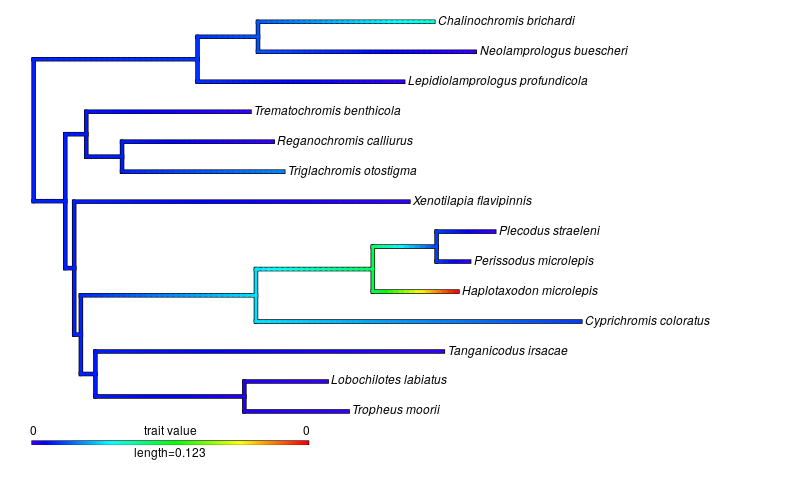

In [70]:
%%R -w 800 -h 480 -u px

# stochastic character mapping

library("phytools")
library("ape")

host_tree <- read.tree("host_tree/mcgeetree/mcgee_trimmed.tree")

phase1_otus <- read.table( file="dissertation_run_host_abundance_table_filtered.tsv", 
                           sep='\t', header=TRUE, row.names=1 )

# use make.simmap() for categorical data : http://www.inside-r.org/packages/cran/phytools/docs/make.simmap
# use contMap() for continious data : http://www.inside-r.org/node/166056

# we need this function to change the color mapping...
# code is from here : http://blog.phytools.org/2014/12/inverting-color-map-on-object-of-class.html
setMap<-function(x,...){
    if(hasArg(invert)) invert<-list(...)$invert
    else invert<-FALSE
    n<-length(x$cols)
    if(invert) x$cols<-setNames(rev(x$cols),names(x$cols))
    else x$cols[1:n]<-colorRampPalette(...)(n)
    x
}

obj <- contMap( host_tree, as.matrix(phase1_otus)[,"CHALBRI.2_10000"], plot=FALSE )
plot(setMap(obj,invert=TRUE))

It would be nice to do a phylogenetic PCA, but alas, the implementation leaves
something to be desired.

In [41]:
%%R -w 800 -h 480 -u px
library('geiger')
library('phytools')

#phase1_otus <- read.table( file="fishpoo_phase1_otus_vs_host.csv", sep=',')
td <- treedata( host_tree, phase1_otus )

#phase1_pca <- phyl.pca( rabosky_trimmed, phase1_otus, method="BM", mode="cov")
phase1_pca <- phyl.pca( host_tree, phase1_otus, method="BM", mode="cov" )


plot(phase1_pca$S[,1:2])
text(phase1_pca$S[,1:2]-0.25,rownames(phase1_pca$S), cex.lab=0.3)

#phylomorphospace( host_tree, phase1_pca$S[,1:2] )


Error: cannot allocate vector of size 61.5 Gb


We can call these phylogenetic signal functions from `Python` using
`rpy2` as a wrapper, but we'll need some biolerplate to remap their
namespaces. Also, can someone please tell `R` about namespaces? That
would be great.

We also define a function here to take lists of sequence names in 
`Python` and return the `R` data structure expected by the signal
functions.

In [71]:
# Let's try to talk to R from python. Then I don't have to figure out 
# how to do parsing, logic and flow control in R anymore

from rpy2.robjects.packages import importr
import rpy2.robjects as ro

# R namespaces are kind of a joke
ape_translations = {'delta.plot'            : 'delta_plot',
                    'delta_plot'            : 'delta__plot',
                    'dist.dna'              : 'dist_dna',
                    'dist_dna'              : 'dist__dna',
                    'dist.nodes'            : 'dist_nodes',
                    'dist_nodes'            : 'dist__nodes',
                    'node.depth'            : 'node_depth',
                    'node_depth'            : 'node__depth',
                    'node.depth.edgelength' : 'node_depth_edgelength',
                    'node_depth_edgelength' : 'node__depth__edgelength',
                    'node.height'           : 'node_height',
                    'node_height'           : 'node__height', 
                    'node.height.clado'     : 'node_height_clado',
                    'node_height_clado'     : 'node__height__clado',
                    'prop.part'             : 'prop_part',
                    'prop_part'             : 'prop__part', }
ape = importr('ape', robject_translations = ape_translations )

phytools = importr('phytools')

adephylo = importr('adephylo')
phylobase = importr('phylobase')

# read in the big fish tree
host_tree = ape.read_tree( "host_tree/mcgeetree/mcgee_trimmed.tree" )

def tree_trait( otu_names, debug=False ) :
    # The bacteria/archaea tree may contain leaves that are not in
    # our OTU table. Those weren't observed, so we just drop them;
    # it works out the same as zero counts for all hosts.
    #otu_names = set(merged_counts.columns).intersection( set(map( lambda l : l.taxon.label, node.leaf_nodes() )) )
    trait_table = df[ otu_names ].sum(axis=1).to_dict()
    #for key in trait_table.keys() :
    #    trait_table[ key.replace( ' ', '_' ) ] = trait_table[key]
    #    del trait_table[key]
    if debug : print trait_table
    r_trate_table = ro.vectors.FloatVector(trait_table.values())
    r_trate_table.names = trait_table.keys()
    return r_trate_table

The signal functions don't work correctly on traits that aren't associated
with any host. We do have some sequences in our trait table that were only
found in the control samples, which are not part of the host tree. So, we
need to remove those tops from hour microbe tree.

In [10]:
import dendropy

# walk through the microbe tree, return list of OTUs for each node in the tree 
microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_clustalo_fasttree.tree', 
                                  schema='newick', preserve_underscores=True)

# drop leafs that don't have any observations (we previously droped non-host control samples,
# so not all OTUs are observed in the hosts)
drop_leafs = set(i.taxon.label for i in microbe_tree.leaf_nodes()) - set(df.columns)
microbe_tree.prune_taxa_with_labels(drop_leafs)
microbe_tree.write( path='dissertation_run_unique_2_pruned.tree', schema='newick')

print 'dropped', len(drop_leafs), 'taxa, final tree :', len(microbe_tree.leaf_nodes()), 'taxa'

dropped 12588 taxa, final tree : 90858 taxa


Now, we can walk through the nodes of the microbe tree and integrate
the observations of the leafs that descend from each node into a single 
"trait." We then compute the phylogenetic signal of each of these traits
using four methods from the literature.

This allows us to look at the phylogenetic signal not only of the
individual microbial observations, but also of groupings organized
according to their phylogeny.

In [73]:
from pyprind import ProgBar

progbar = ProgBar( len(microbe_tree.nodes()), monitor=True, title='Listening for phylogenetic signal...' )

f = open( 'dissertation_run_unique_2_phylosig.csv', 'w' )
f.write( ','.join(['n', 'otu', 'leafs', 'K', 'l_lambda', 'l_logL', 'I', 'Cmean']) + '\n' )
#for n,node in enumerate( microbe_tree.postorder_node_iter() ) :
for n,node in enumerate( microbe_tree.preorder_node_iter() ) : 
    leafs = map( lambda l : l.taxon.label, node.leaf_nodes() )
    K = phytools.phylosig( host_tree, tree_trait( leafs ), method='K' )[0]
    l_lambda, l_logL = map( lambda x : x[0], phytools.phylosig( host_tree, tree_trait( leafs ), method='lambda' ) )
    I = adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tree_trait( leafs ) ), method="Abouheif" )[0][0]
    Cmean = adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tree_trait( leafs ) ), method="oriAbouheif" )[0][0]
    node.annotations.add_new( 'Bloomberg K', K )
    node.annotations.add_new( 'Pagel lambda', l_lambda )
    node.annotations.add_new( 'Pagel logL', l_logL )
    node.annotations.add_new( 'Moran I', I )
    node.annotations.add_new( 'Abouheif Cmean', Cmean )
    if node.is_internal() :
        otu = None
    else :
        otu = node.taxon.label
    node.label = n
    f.write( ','.join(map(str,[n, otu, len(leafs), K, l_lambda, l_logL, I, Cmean])) + '\n' )
    #if n%1000 == 0 : print n, node.is_internal(), len(leafs), K, l_lambda, l_logL, I, Cmean
    progbar.update()
f.close()

Listening for phylogenetic signal...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 01:57:48


In [8]:
microbe_tree.write( path='dissertation_run_unique_2_phylosig.nex', schema='nexus')

In [74]:
import pandas as pd

ps = pd.read_csv( 'dissertation_run_unique_2_phylosig.csv', index_col=0 )
ps.head()

,otu,leafs,K,l_lambda,l_logL,I,Cmean
n,,,,,,,
0,None,90858,0.551565,0.015445,379.888668,0.084671,0.142647
1,None,307,0.667240,0.088016,81.337118,0.004947,0.058462
2,None,301,0.666342,0.088602,81.378300,0.004763,0.058046
3,None,297,0.668383,0.092965,81.393562,0.006084,0.059395
4,None,67,0.599815,0.000066,91.401824,-0.067917,-0.011507


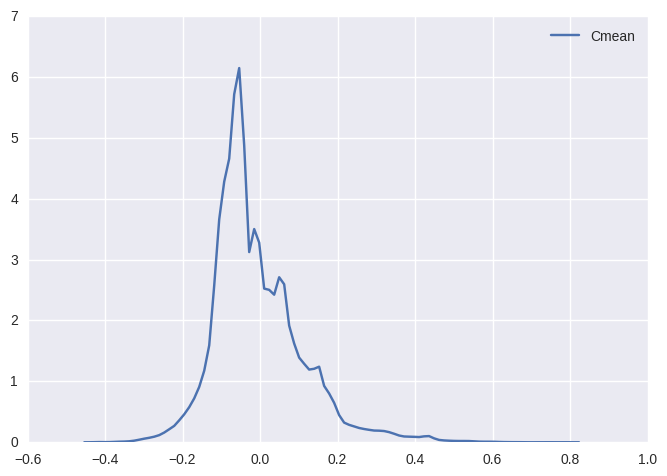

In [10]:
import seaborn

seaborn.kdeplot( ps['Cmean'] )

Since we have phylogenetic signal for all of the microbial sequences
at every phylogenetic level, we can look at how the signal is distributed
over the tree of microbes.

Plotting phylogenetic signal...
0%                          100%
[###############               ] | ETA: 00:32:16

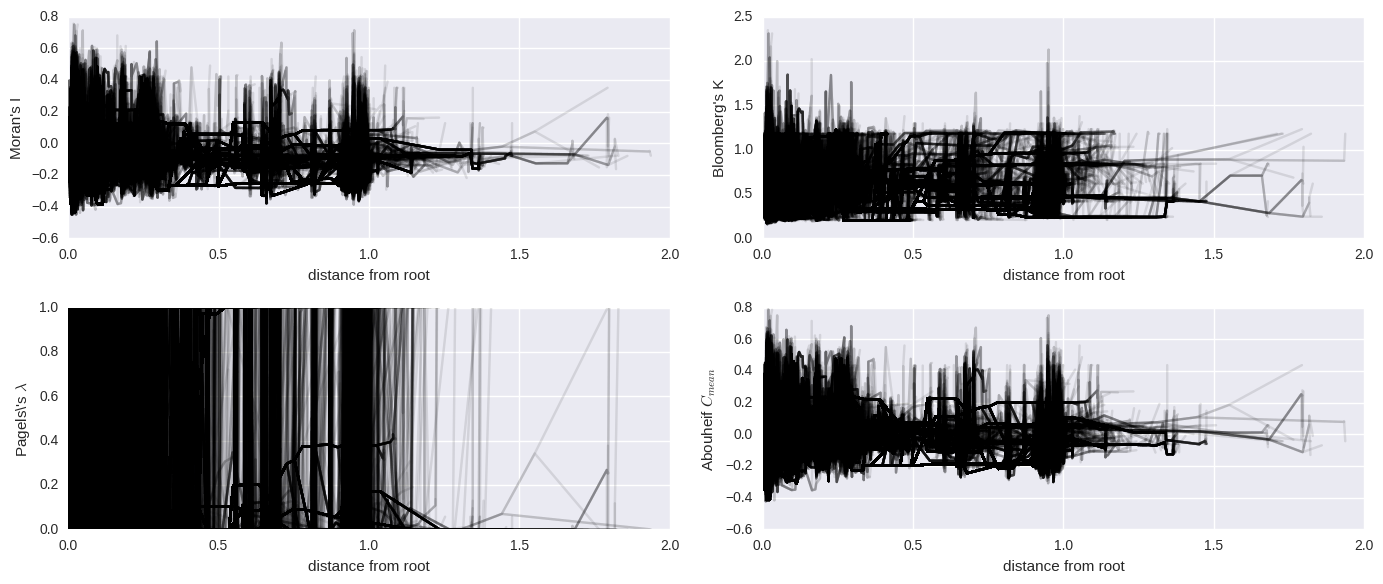

In [23]:
figure(figsize=(14, 6))

progbar = ProgBar( len(microbe_tree.nodes()), monitor=True, title='Plotting phylogenetic signal...' )

for n,leaf in enumerate( microbe_tree.leaf_node_iter() ) :
    #if n == 100 : break
    d = leaf.distance_from_root()
    ds, dt, ks, ls, ms, cs = [],[],[],[],[],[]
    i = leaf
    while i : 
        ds.append( i.distance_from_root() )
        dt.append( i.distance_from_tip() )
        ks.append( i.annotations['Bloomberg K'].value )
        ls.append( i.annotations['Pagel lambda'].value )
        ms.append( i.annotations['Moran I'].value )
        cs.append( i.annotations['Abouheif Cmean'].value )
        i = i.parent_node
    #print leaf., leaf.parent_node, ds
    subplot(221)
    plot(ds,ms,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel('Moran\'s I')
    
    subplot(222)
    plot(ds,ks,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel('Bloomberg\'s K')
    
    subplot(223)
    plot(ds,ls,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel( r'Pagels\'s $\lambda$')
        
    subplot(224)
    plot(ds,cs,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel( r'Abouheif $C_{mean}$')
    progbar.update()
tight_layout()

This is interesting, but unfortunately it is very difficult to interpret.

Let's have a look at the phylogenetic signal of some individual microbial sequences. 

In [78]:
#ps[ ps['internal'] == False ].sort_values(by='K',ascending=False)
ps[ ps['otu'] != 'None'].head()

,otu,leafs,K,l_lambda,l_logL,I,Cmean
n,,,,,,,
10,HAPLMIC1_10273,1,0.417820,0.000066,196.486154,-0.078101,-0.060096
12,CYPRCOL6_171436,1,0.824697,0.000066,165.960092,-0.139779,-0.003703
14,CYPRCOL2_37951,1,0.825639,0.000066,167.686754,-0.092346,0.157641
15,TANGIRA1_2066,1,0.755231,0.999934,168.192734,-0.055822,0.055618
17,CYPRCOL2.2_58731,1,0.801841,0.000066,167.827466,-0.091202,0.165087


In [123]:
trait_table = ps[ ps['otu'] != 'None'].join( df.T, on='otu' ).set_index('otu')
trait_table['total'] = df.sum()

trait_table[ trait_table['total'] > .001 ].sort_values('l_lambda', ascending=False)

,leafs,K,l_lambda,l_logL,I,Cmean,Chalinochromis_brichardi,Cyprichromis_coloratus,Haplotaxodon_microlepis,Lepidiolamprologus_profundicola,...,Neolamprologus_buescheri,Perissodus_microlepis,Plecodus_straeleni,Reganochromis_calliurus,Tanganicodus_irsacae,Trematochromis_benthicola,Triglachromis_otostigma,Tropheus_moorii,Xenotilapia_flavipinnis,total
otu,,,,,,,,,,,,,,,,,,,,,
CHALBRI1_5573,1,0.954295,0.999953,109.275035,0.179298,0.220022,0.000202,3.012014e-04,0.000112,0.000261,...,0.000185,0.000046,0.000043,0.000261,0.000264,0.000300,0.000201,0.000009,0.000364,0.002757
CHARCNT_20,1,0.652637,0.999934,63.884994,-0.071890,0.059207,0.000000,9.278715e-06,0.000010,0.000012,...,0.000021,0.000000,0.000000,0.000000,0.000005,0.008598,0.000006,0.000000,0.000117,0.008778
CHALBRI1_1284,1,1.053816,0.999934,89.965434,0.084657,0.172053,0.000458,7.758434e-04,0.000274,0.000915,...,0.000646,0.000137,0.000128,0.000661,0.000843,0.000761,0.000595,0.000100,0.001923,0.008909
CHARCNT_2424,1,0.663554,0.999934,65.944309,-0.050939,0.078405,0.000000,0.000000e+00,0.000298,0.000000,...,0.000000,0.000068,0.000106,0.000546,0.000005,0.007522,0.000000,0.000000,0.000000,0.008545
HAPMIC3.2_27788,1,0.651629,0.999934,90.684411,-0.074101,0.057349,0.000000,0.000000e+00,0.000008,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000005,0.001267,0.000000,0.000000,0.000007,0.001287
PERIMIC1_43671,1,0.650361,0.999934,92.503356,-0.075444,0.056191,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000011,0.000000,0.000000,0.000002,0.001112,0.000000,0.000000,0.000000,0.001126
CHALBRI.2_59542,1,0.606248,0.999934,72.802739,-0.062756,0.005082,0.000003,3.568737e-06,0.000000,0.000113,...,0.000000,0.000000,0.000000,0.004549,0.000000,0.000145,0.000022,0.000000,0.000000,0.004836
CHALBRI.2_12071,1,0.608060,0.999934,87.170703,-0.058310,0.009046,0.000007,7.137473e-07,0.000000,0.000059,...,0.000007,0.000000,0.000021,0.001637,0.000002,0.000070,0.000014,0.000000,0.000000,0.001819
CHALBRI.2_5937,1,0.606248,0.999934,25.383015,-0.063454,0.004351,0.000109,1.698719e-04,0.000016,0.005589,...,0.000305,0.000034,0.000000,0.134681,0.000041,0.004216,0.000833,0.000036,0.000000,0.146054


Not sure what we'll do with it, but we may as well write out a tree with
the nodes annotated with the phylogenetic signal of the host. Maybe someone
will find it useful?

In [15]:
import dendropy

microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_phylosig.nex', 
                                  schema='nexus', preserve_underscores=True)

In [63]:
list(microbe_tree.preorder_node_iter())[181688].taxon.label

'LEPIPRO1_98387'

Let's make some plots of sequences with particularly high and low
phylogenetic signal.

png 
  2 


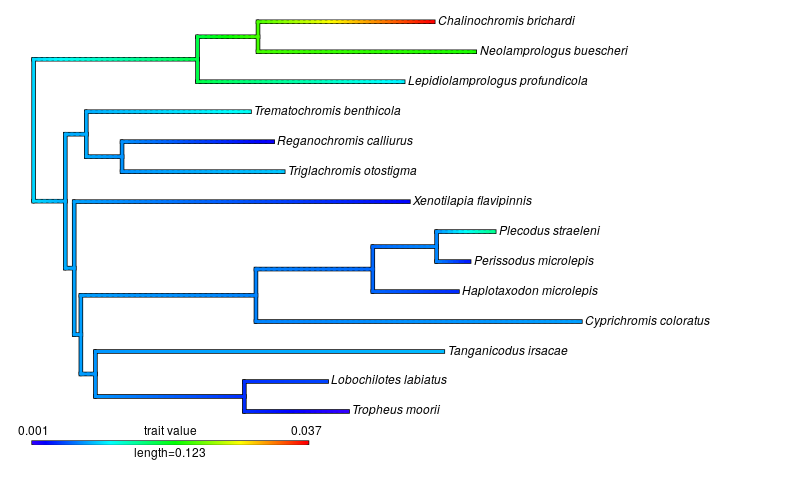

In [122]:
%%R -w 800 -h 480 -u px

# trait values in parts per million
obj <- contMap( host_tree, as.matrix(phase1_otus)[,"CHALBRI1_1198"]*100, plot=FALSE, sig=2 )
plot(setMap(obj,invert=TRUE))

pdf('phylosig_heattree_highsig.pdf', width = 10, height = 5 )
plot(setMap(obj,invert=TRUE))
dev.off()

png 
  2 


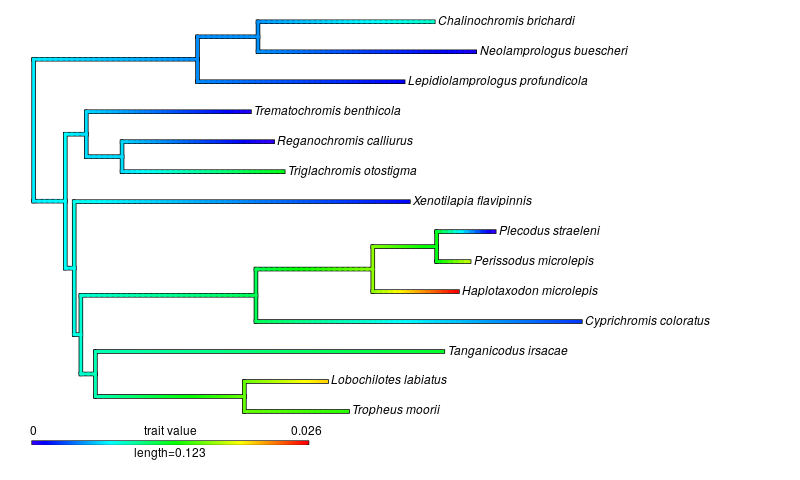

In [120]:
%%R -w 800 -h 480 -u px

# trait values in parts per million
obj <- contMap( host_tree, as.matrix(phase1_otus)[,"CHALBRI1_4931"]*100, plot=FALSE, sig=2 )
plot(setMap(obj,invert=TRUE))

pdf('phylosig_heattree_lowsig.pdf', width = 10, height = 5 )
plot(setMap(obj,invert=TRUE))
dev.off()

## Co-diversification analysis

Phylogenetic signal does not have a way to take relationships among the traits into
account; the hosts may have a phylogney, but the traits are assumed to be independent.
Because of this, we can only use one tree or the other. Either the microbes are traits of
the hosts or the hosts are traits of the microbes, but the traits themselves are
independent. When one doesn't explicitly include a phylogeny of a group of organisms, that
does not mean that you aren't imposing a tree on them -- it just means that you are imposing
the *wrong* tree on them (usually a unit polytomy).

So, let's look at our system as co-diversifying groups. I've written some software called
`SuchTree` to make this computationally feasable.

In [4]:
from SuchTree import SuchTree, SuchLinkedTrees
import pandas as pd

# checkpoint entry point

host_tree = SuchTree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
guest_tree = SuchTree( 'dissertation_run_unique_2_pruned.tree' )
links = pd.read_csv( 'dissertation_run_host_abundance_table_filtered.tsv', sep='\t', index_col=0 )

SLT = SuchLinkedTrees( host_tree, guest_tree, links )

First, we'll look at the correlations of patristic distances among organisms
linked by observed associations, as per Hommola *et al.*

In [2]:
from pyprind import ProgBar
from scipy.stats import spearmanr, kendalltau, pearsonr

progbar = ProgBar( len(SLT.TreeB.get_internal_nodes()), monitor=True, title='Calculating Hommola correlations...' )

data = []
for n,nodeid in enumerate(SLT.TreeB.get_internal_nodes()) :
    #if n > 1000 : break
    SLT.subset_b( nodeid )
    progbar.update()
    if SLT.subset_n_links < 5 :
        continue
    if SLT.subset_n_links < 500 :
        d = SLT.linked_distances()
    else :
        d = SLT.sample_linked_distances()
    r, p = pearsonr( d['TreeA'], d['TreeB'] )
    data.append( ( nodeid, SLT.subset_b_size, SLT.subset_n_links, r, p ) )

Calculating Hommola correlations...
0%                          100%
[##############                ] | ETA: 06:20:27/home/russell/opt/local/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
[##############################] | ETA: 00:00:00
Total time elapsed: 07:00:13


In [3]:
# checkpoint exit point
hommola = pd.DataFrame( data, columns=['nodeid', 'nleafs', 'nlinks', 'r', 'p' ] )
hommola.to_csv( 'dissertation_run_hommola_correlations.csv', sep=',' )

In [335]:
# checkpoint entry point
hommola = pd.read_csv( 'dissertation_run_hommola_correlations.csv', sep=',', index_col=1 )[['nleafs','nlinks','r','p']]
hommola.head()

,nleafs,nlinks,r,p
nodeid,,,,
135279,90858,235883,0.000323,5.505505e-01
197,67640,169823,0.009309,1.853826e-36
135893,23218,66060,-0.004880,1.504688e-05
115,99,240,-0.043674,1.367758e-13
134845,67541,169583,0.008778,7.605455e-46


For context, let's load a couple of interactions where the ecology is well
understood. We'll use the classic Gopher/Louse dataset from Hafner *et al.*
and the Sedge/Smut dataset from Escudero. 

In [193]:
from scipy.stats import spearmanr, kendalltau, pearsonr

SLT_gopher_louse = SuchLinkedTrees( SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/gopher.tree'),
                                    SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/lice.tree'),
                                    pd.read_csv('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/links.csv', index_col=0) )
d = SLT_gopher_louse.linked_distances()
gl_r, gl_p = pearsonr( d['TreeA'], d['TreeB'] )
gl_nleafs = SLT_gopher_louse.TreeB.n_leafs
print 'size of guest tree       :', gl_nleafs
print 'Hommola correlation      :', gl_r
print 'Correlation significance :', gl_p

size of guest tree       : 17
Hommola correlation      : 0.490184989686
Correlation significance : 1.38477623452e-09


In [89]:
from scipy.stats import spearmanr, kendalltau, pearsonr

SLT_sedge_smut = SuchLinkedTrees( SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/sedge-smut/host.tree'),
                                  SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/sedge-smut/guest.tree'),
                                  pd.read_csv('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/sedge-smut/links.csv', index_col=0) )
d = SLT_sedge_smut.linked_distances()
sm_r, sm_p = pearsonr( d['TreeA'], d['TreeB'] )
sm_nleafs = SLT_sedge_smut.TreeB.n_leafs
print 'size of guest tree       :', sm_nleafs
print 'Hommola correlation      :', sm_r
print 'Correlation significance :', sm_p

size of guest tree       : 27
Hommola correlation      : 0.151791281195
Correlation significance : 1.2693168737e-05


Putting our unknown interactions in context with the Gopher/Louse and
Sedge/Smut interactions, we have something that is a little easier to
interpret, but it's clear that the signal-to-noise ratio of non-idealized
interactions is going to be a problem.

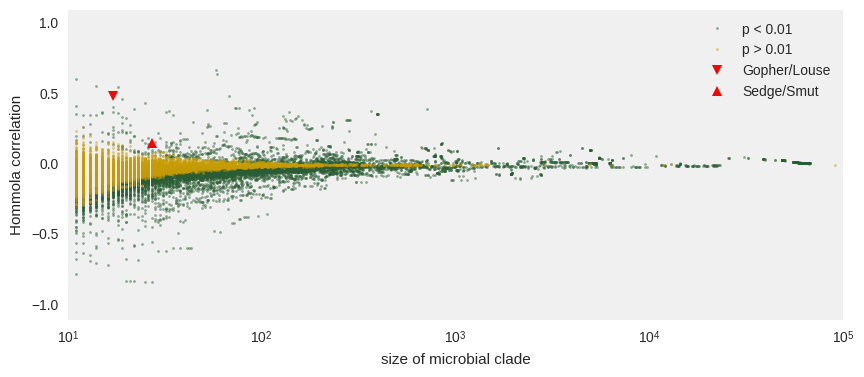

In [207]:
import seaborn

figure(figsize=(10, 4))

with seaborn.axes_style("white"):
    subplot( axisbg='#F0F0F0' )
    ax = plot( hommola[ (hommola.nleafs > 10) & (hommola.p < 0.01) ].nleafs, 
          hommola[ (hommola.nleafs > 10) & (hommola.p < 0.01) ].r, 
          linewidth=0, color=seaborn.xkcd_rgb['pine'],
          marker='o', alpha=0.5, markersize=2,
          label='p < 0.01' )
    ax = plot( hommola[ (hommola.nleafs > 10) & (hommola.p > 0.01) ].nleafs, 
          hommola[ (hommola.nleafs > 10) & (hommola.p > 0.01) ].r, 
          linewidth=0, color=seaborn.xkcd_rgb['ocre'],
          marker='o', alpha=0.5, markersize=2,
          label='p > 0.01' )
    for side in ax[0].axes.spines.keys() :
            ax[0].axes.spines[side].set_visible(False)
    plot( [gl_nleafs], [gl_r], linewidth=0, color='red', marker='v', label='Gopher/Louse' )
    plot( [sm_nleafs], [sm_r], linewidth=0, color='red', marker='^', label='Sedge/Smut' )
    semilogx()
    #axhline(0.1, linewidth=1, linestyle='-', color='black', alpha=0.9)
    ylim(-1.1,1.1)
    xlabel( 'size of microbial clade')
    ylabel( 'Hommola correlation')
    legend()
    
savefig( 'Hommola_correlations.png', dpi=300 )

In [128]:
bigR = hommola[ (hommola.nleafs > 10) & (hommola.p < 0.01) & (hommola.r > 0.1) ]
bigR = bigR.sort_values('r', ascending=False)
bigR.head(10)

,nodeid,nleafs,nlinks,r,p
47124,72311,58,70,0.673018,2.036692e-318
46566,72339,59,73,0.645670,6.499896e-310
39283,82279,11,13,0.611837,2.662861e-09
35848,22929,14,17,0.560684,1.259824e-12
54994,77871,18,23,0.554529,8.442660e-22
46000,72223,68,87,0.488079,3.206487e-223
35533,22919,19,22,0.468834,5.027105e-14
33466,110467,25,50,0.438492,1.014460e-58
46415,46249,11,18,0.417645,7.823672e-08
55617,77839,17,22,0.408787,1.019988e-10


Exmaining these correlations more closely reveals why. Correlation
tests are not well suited for unsupervised data exploration.

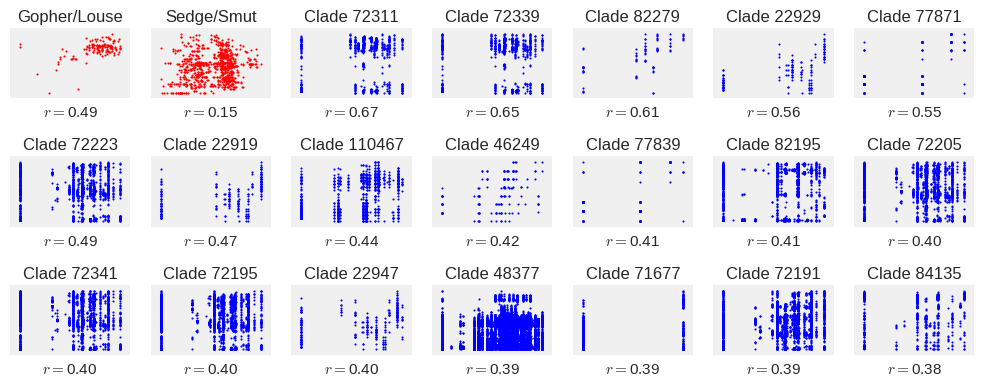

In [124]:
figure(figsize=(10, 4))

with seaborn.axes_style("white") :
    
    subplot(3,7,1, axisbg='#F0F0F0')
    #axis('off')
    d = SLT_gopher_louse.linked_distances()
    r,p = pearsonr(d['TreeA'], d['TreeB'])
    ax = plot( d['TreeA'], d['TreeB'], linewidth=0, color='red', marker='o', markersize=1.5  )
    ax[0].axes.set_xticks( [] )
    ax[0].axes.set_yticks( [] )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    ax[0].axes.margins( 0.1, 0.1 )
    title( 'Gopher/Louse' )
    xlabel( r'$r=$%1.2f' % r )
    
    subplot(3,7,2, axisbg='#F0F0F0')
    #axis('off')
    d = SLT_sedge_smut.linked_distances()
    r,p = pearsonr(d['TreeA'], d['TreeB'])
    ax = plot( d['TreeA'], d['TreeB'], linewidth=0, color='red', marker='o', markersize=1.5 )
    ax[0].axes.set_xticks( [] )
    ax[0].axes.set_yticks( [] )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    ax[0].axes.margins( 0.1, 0.1 )
    title( 'Sedge/Smut' )
    xlabel( r'$r=$%1.2f' % r )
        
    for m,(n,row) in enumerate(bigR.iterrows()) :
        if m >= 19 : break
        subplot(3,7,m+3, axisbg='#F0F0F0')
        #axis('off')
        SLT.subset_b(row.nodeid)
        d = SLT.linked_distances()
        r,p = pearsonr(d['TreeA'], d['TreeB'])
        ax = plot( d['TreeA'], d['TreeB'], linewidth=0, color='blue', marker='o', markersize=1.5 )
        ax[0].axes.set_xticks( [] )
        ax[0].axes.set_yticks( [] )
        for side in ax[0].axes.spines.keys() :
            ax[0].axes.spines[side].set_visible(False)
        ax[0].axes.margins( 0.1, 0.1 )
        title( 'Clade ' + str(int(row.nodeid)) )
        xlabel( r'$r=$%1.2f' % r )

tight_layout()
    
savefig( 'High_correlation_clades.png', dpi=300 )

When we look at the distributions of linked patristic distances, this
doesn't look like a real correlation at all. Nevertheless, the Hommola
test predicts that it ought to be, and with high confidence.

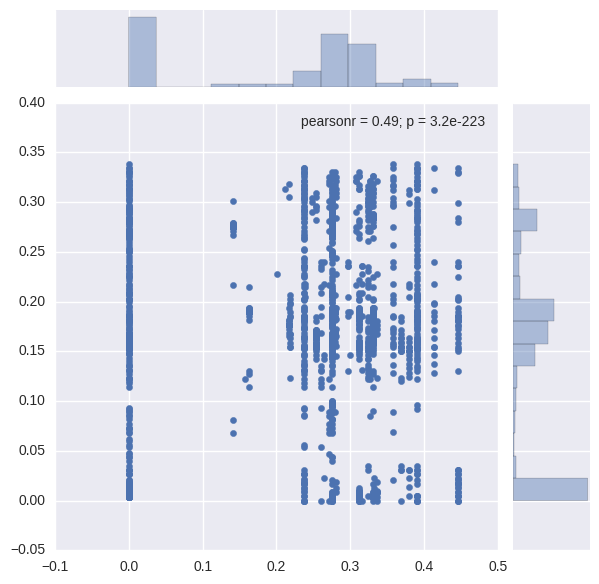

In [20]:
import seaborn

cladeid = 72223

SLT.subset_b( cladeid )
d = SLT.linked_distances()
seaborn.jointplot( d['TreeA'], d['TreeB'] )

This is even more clear when we look at the tanglegrams.

First, let's look at how clade 72223 interacts with the host
phylogeny...

In [22]:
import dendropy

microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_pruned.tree', 
                                  schema='newick', preserve_underscores=True)

sfeal = dict( zip( SLT.TreeB.leafs.values(), SLT.TreeB.leafs.keys() ) )
clade_leafs = [ sfeal[nodeid] for nodeid in SLT.subset_b_leafs ]

microbe_tree.retain_taxa_with_labels( clade_leafs )

microbe_tree.write( path='dissertation_run_clade_72223.tree', schema='newick' )

In [59]:
clinks = links[ clade_leafs ]
uclinks = clinks.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( str(cladeid) + '.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join([ ''+i+'' for i in pair[::-1] ]) + '\n' )

In [60]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Rotating nodes to optimize matching...
Done.
png 
  2 


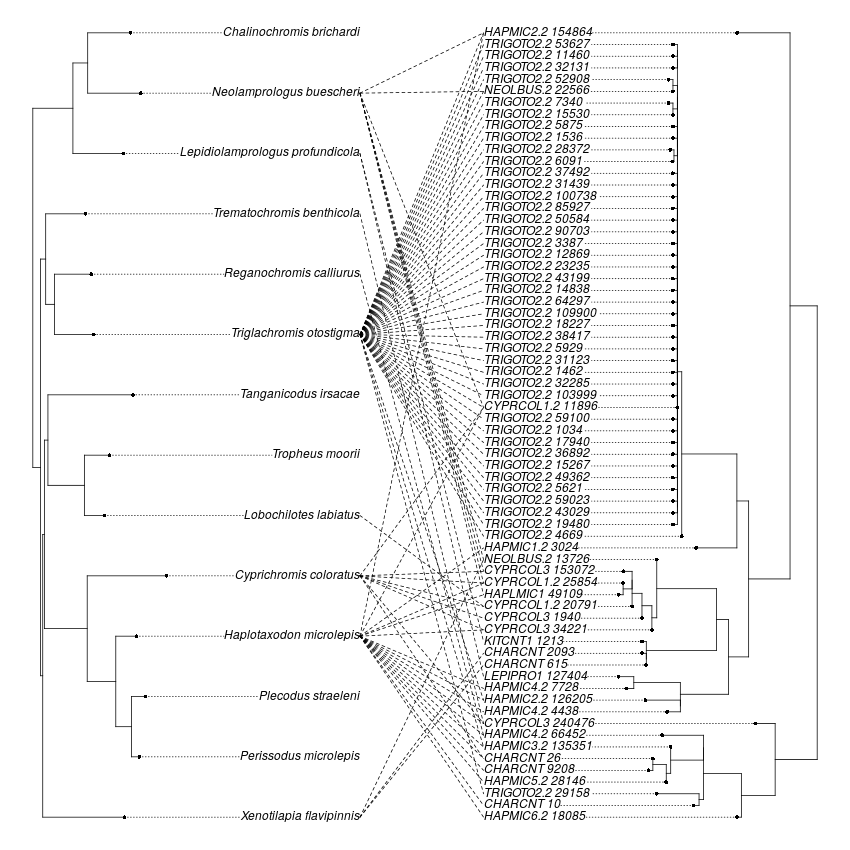

In [85]:
%%R -w 30 -h 30 -u cm

library('phytools')

tr1 <- read.tree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
tr2 <- read.newick( 'dissertation_run_clade_72223_edit.tree' )
tr2 <- collapse.singles(tr2)
assoc = as.matrix(read.csv( '72223.links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

obj <- cophylo( tr1, tr2, assoc=assoc )
plot(obj)

pdf('codiv_clade_72223.pdf', width = 10, height = 12 )
plot(setMap(obj,invert=TRUE))
dev.off()

Now, let's look at Gopher/Louse from Hafner *et al.*.

In [80]:
links = pd.read_csv('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/links.csv', index_col=0)

uclinks = links.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( 'gopher-louse.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join([ ''+i+'' for i in pair[::-1] ]) + '\n' )

There are obviously different processes going on here.

Rotating nodes to optimize matching...
Done.
png 
  2 


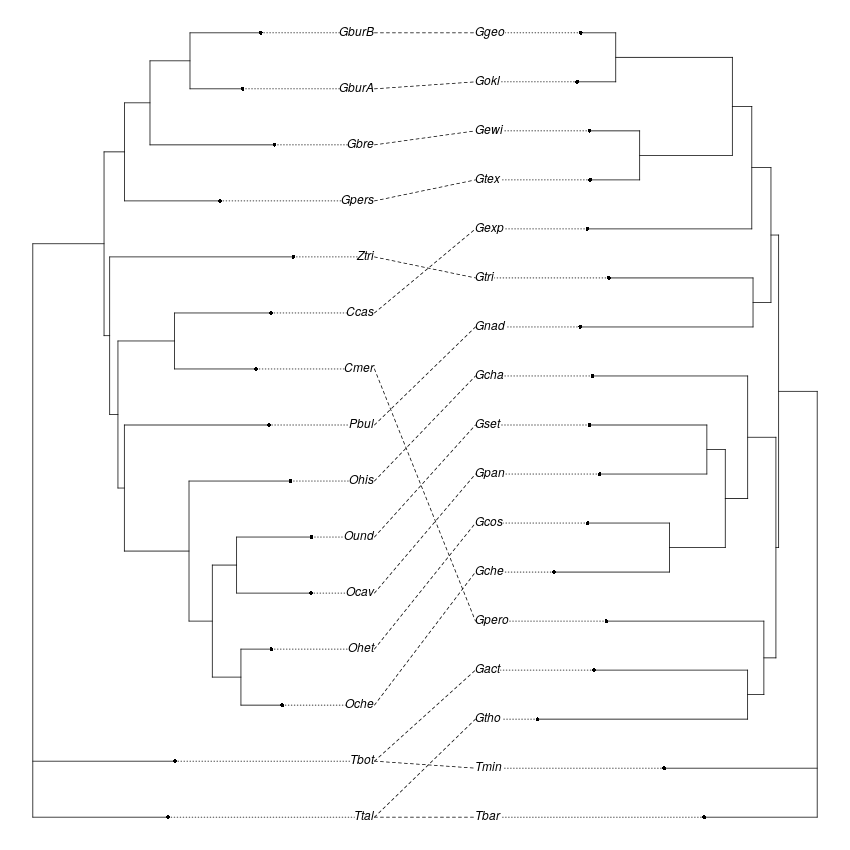

In [86]:
%%R -w 30 -h 30 -u cm

library('phytools')

tr1 <- read.tree( '../SuchTree/data/gopher-louse/gopher.tree' )
tr2 <- read.newick( '../SuchTree/data/gopher-louse/lice.tree' )
tr2 <- collapse.singles(tr2)
assoc = as.matrix(read.csv( 'gopher-louse.links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

obj <- cophylo( tr1, tr2, assoc=assoc )
plot(obj)

pdf('codiv_gopher_louse.pdf', width = 10, height = 12 )
plot(setMap(obj,invert=TRUE))
dev.off()

## Spectral analysis

Patristic distances are a property of a phylognetic tree, but they do not
represent the structure itself. Many topologies may have the same distance
matrix. If this were not the case, then neighbor joining, UPGMA, parsimony,
maximum likelihood and Baysean phylogenetic methods would all produce the
same trees from the same data.

Instead of exmaining correlations of linked patristic distances, we will
examine the spectral properties of the networks formed by interacting trees.
The graph Laplacian matrixes of these networks are a full representation of
all of evolutionary information in the trees and all ecological information
in the interactions.

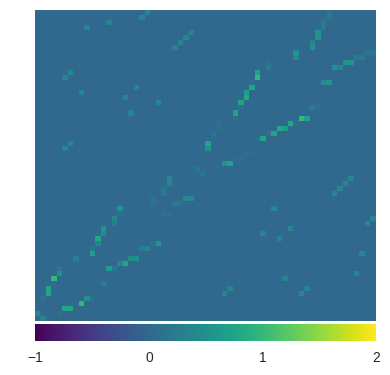

In [145]:
figure(figsize=(4,4))
aj = SLT_gopher_louse.adjacency()
pcolor(aj, cmap='viridis', vmin=-1, vmax=2)
xlim( (0,aj.shape[0]) )
ylim( (0,aj.shape[1]) )
#xticks([])
#yticks([])
axis('off')
colorbar( ticks=[-1,0,1,2], orientation='horizontal', pad=0.01 )
tight_layout()

savefig( 'gopher_louse_adjacency.png', dpi=100 )

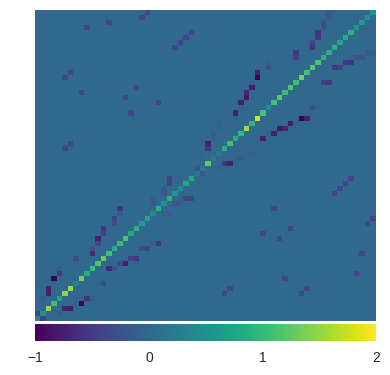

In [146]:
figure(figsize=(4,4))
lp = SLT_gopher_louse.laplacian()
pcolor(lp, cmap='viridis', vmin=-1, vmax=2)
xlim( (0,lp.shape[0]) )
ylim( (0,lp.shape[1]) )
#xticks([])
#yticks([])
axis('off')
colorbar( ticks=[-1,0,1,2], orientation='horizontal', pad=0.01 )
tight_layout()

savefig( 'gopher_louse_laplacian.png', dpi=300 )

There is a chance that two cospectral may not be isomorphic, but the
probability is low for graphs of intermediate size. So, we can reasonably
treat the the spectrum of the Laplacian matrix as (almost certainly) unique
to that graph.

The Laplacian spectrum represents the steady state of a random walk, and is
a useful metric for local connectivity.

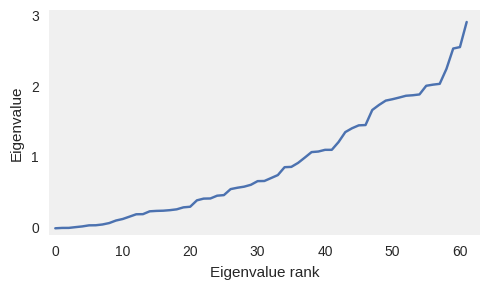

In [194]:
figure(figsize=(5,3))

lambdas = SLT_gopher_louse.spectrum()

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')
    ax = plot( lambdas )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'Eigenvalue rank' )
    ylabel( 'Eigenvalue' )
    ax[0].axes.set_yticks([0,1,2,3])
    xlim( [-1,63] )
    ylim( [-0.1,3.1] )

tight_layout()

savefig( 'gopher_louse_eigenvalues.pdf', dpi=100 )

Of course, graphs of different sizes will have Laplacians of different
rank, and thus different numbers of eigenvalues. We would like to use
the spectra to compare the structures of different graphs, and so it is
helpful to project the spectra into a uniform space.

To do this, we use a Gausian kernel density estimator, which transforms
descrete functions into continuous distributions.

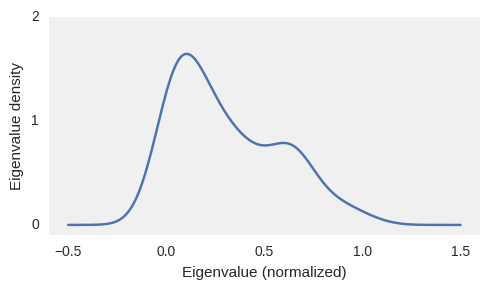

In [195]:
from scipy.stats import skew, entropy, gaussian_kde, kurtosis

figure(figsize=(5,3))

bandwidth = 0.4
lambdas = SLT_gopher_louse.spectrum()

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')
    X = linspace( -0.5,1.5,200 )
    ax = plot( X, gaussian_kde( lambdas/max(lambdas), bw_method=bandwidth ).pdf( X ) )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'Eigenvalue (normalized)' )
    ylabel( 'Eigenvalue density' )
    ax[0].axes.set_yticks([0,1,2])
    xlim( [-0.6,1.6] )
    ylim( [-0.1,2] )

tight_layout()

savefig( 'gopher_louse_spectral_density.pdf', dpi=100 )

Spectral density distributions can be compared using their Shanon-Jensen 
distance, which we'll define here.

We'd like to explore how diverging graph topologies relate to the 
Shanon-Jensen distance of their Laplacian spectral density distributions,
so we'll also define a function to generate some permutations on
graphs.

In [2]:
import igraph

def permute_links( linklist, deletions, additions, swaps ) :
    ll = array( linklist )
    for i in xrange( 1, deletions ) :
        ll = delete( ll, randint(len(ll)), axis=0 )
    for i in xrange( 1, swaps ) :
        x, y = random.choice( xrange( len(ll) ), size=2, replace=False )
        X, Y = ll[x,1], ll[y,1]
        ll[x,1] = Y
        ll[y,1] = X
    for i in xrange( 1, additions ) :
        a = random.choice( SLT.TreeA.leafs.values() )
        b = random.choice( SLT.TreeB.leafs.values() )
        ll = numpy.concatenate( (ll, array([[b,a]])), axis=0 )
    return ll

def edge_mean( aj ) :
    return mean( aj.flatten()[ aj.flatten() > SLT.TreeA.polytomy_distance ] )

def pdd( a, b ) :
    '''Jensen–Shannon distance'''
    return ( 0.5 * entropy( a, b ) + 0.5 * entropy( b, a ) )**(0.5)

def graph_spectral_density( SLT, deletions=0, additions=0, swaps=0, mode='lambdas' ) :
    
    linklist = permute_links( SLT.linklist, deletions, additions, swaps )
    
    host_aj,  host_node_ids  = SLT.TreeA.adjacency( SLT.TreeA.root ).values()
    guest_aj, guest_node_ids = SLT.TreeB.adjacency( SLT.TreeB.root ).values()
    
    host_node_ids, guest_node_ids = host_node_ids.tolist(), guest_node_ids.tolist()
    
    guest_aj_links = map( lambda x : guest_node_ids.index(x) + host_aj.shape[0] , linklist[:,0] )
    host_aj_links  = map( lambda x : host_node_ids.index(x), linklist[:,1] )
    #zip(guest_aj_links, host_aj_links )
    
    aj = zeros( ( host_aj.shape[0] + guest_aj.shape[0], host_aj.shape[1] + guest_aj.shape[1] ) )
    aj[ 0:host_aj.shape[0], 0:host_aj.shape[1] ] = host_aj / host_aj.max()
    aj[ host_aj.shape[0]:, host_aj.shape[1]: ] = guest_aj / guest_aj.max()
    
    host_mean  = edge_mean( host_aj  / host_aj.max()  )
    guest_mean = edge_mean( guest_aj / guest_aj.max() )
    
    for i,j in zip( guest_aj_links, host_aj_links ) :
        aj[i,j] = ( host_mean + guest_mean ) / 2.0
        aj[j,i] = ( host_mean + guest_mean ) / 2.0
        
    if mode == 'adjacency' :
        return aj
    
    g = igraph.Graph.Weighted_Adjacency( aj.tolist(), mode=igraph.ADJ_UNDIRECTED )
    lp = matrix(g.laplacian( weights='weight', normalized=False ))
    
    host_g = igraph.Graph.Weighted_Adjacency(  host_aj.tolist(),  mode=igraph.ADJ_UNDIRECTED )
    guest_g = igraph.Graph.Weighted_Adjacency( guest_aj.tolist(), mode=igraph.ADJ_UNDIRECTED )
    
    host_lp  = matrix( host_g.laplacian(  weights='weight', normalized=False ))
    guest_lp = matrix( guest_g.laplacian( weights='weight', normalized=False ))
    
    if mode == 'laplacian' :
        return lp
    
    lambdas   = linalg.eigvalsh( lp )
    lambdas_h = linalg.eigvalsh( host_lp )
    lambdas_g = linalg.eigvalsh( guest_lp )
    return { 'graph' : lambdas, 'host' : lambdas_h, 'guest' : lambdas_g }

This is what the Laplacians of our permuted graphs look like...

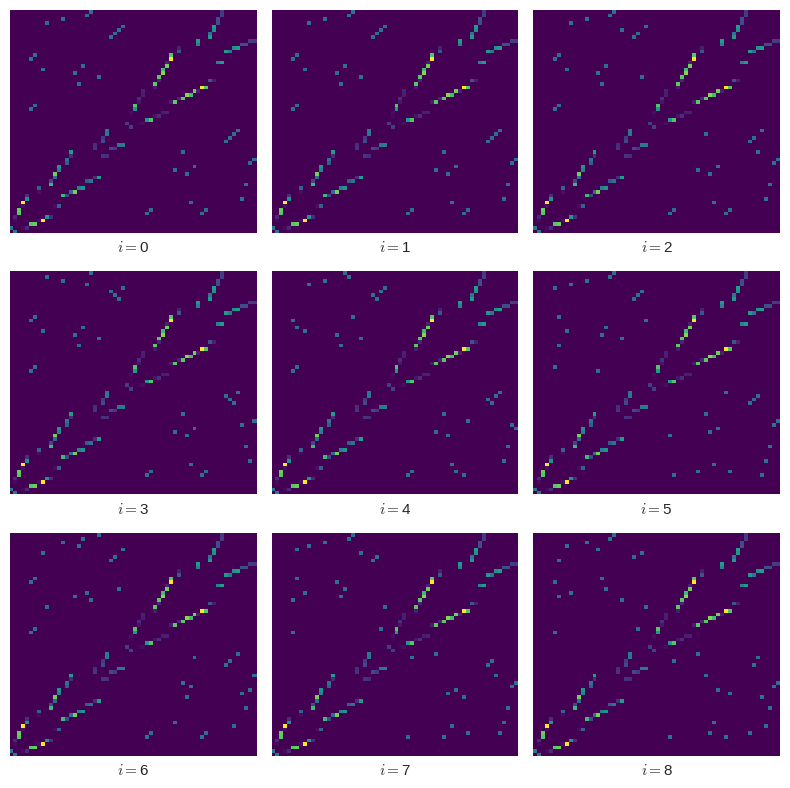

In [227]:
figure(figsize=(8,8))
for i in xrange( 9 ) :
    subplot(3,3,i+1)
    aj = graph_spectral_density( SLT_gopher_louse, additions=0, deletions=0, swaps=i, mode='adjacency' )
    ax = pcolor( aj, cmap='viridis', vmin=0, vmax=1 )
    xlim( (0,aj.shape[1]) )
    ylim( (0,aj.shape[0]) )
    
    ax.axes.set_xticks( [] )
    ax.axes.set_yticks( [] )
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    ax.axes.margins( 0.1, 0.1 )
    xlabel( r'$i=$%d' % i )

tight_layout()

savefig( 'gopher_louse_adjacency_permutations.png', dpi=300 )

...and here is what the spectral density distributions of the permuted
graphs look like...

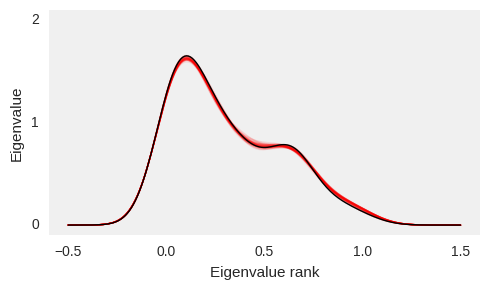

In [325]:
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pyprind

figure( figsize=(5,3) )

bandwidth = 0.4

L,spectra = [],[]
for i in linspace( 0, 50, 51 ) :
    lambdas = graph_spectral_density( SLT_gopher_louse, additions=0, deletions=0, swaps=int(i) )['graph']
    L.append(lambdas)

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')
    
    for i,lambdas in enumerate(L[::-1]) :
        spectra.append( gaussian_kde( lambdas / max(lambdas), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) ) )
        #seaborn.kdeplot( lambdas / lambdas.max(), label=int(i), bw=0.1 )
        if i == 50 :
            c = 'black'
            a = 1.0
        else :
            c = 'red'
            a = 0.1
        ax = plot( linspace( -0.5,1.5,200), spectra[-1], color=c, alpha=a, linewidth=1 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'Eigenvalue rank' )
    ylabel( 'Eigenvalue' )
    ax[0].axes.set_yticks( [0,1,2] )
    xlim( [-0.6,1.6] )
    ylim( [-0.1,2.1] )

tight_layout()

savefig( 'gopher_louse_spectral_density_permutations.pdf', dpi=100 )

...and here is how ther Shanon-Jensen distances vary as the intensity of permutation
on the original graph increases.

We are only permuting the links, not the whole graph topology, and we are doing so only by
swapping random pairs of links. The distance saturates as the number of swapped links reaches
the number of links present. When all of the links have already been randomly swapped, 
swapping them again simply moves the permuted graph around within an annulus of function space. 

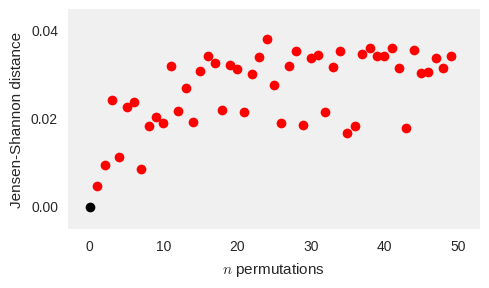

In [327]:
figure( figsize=(5,3) )

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    a = gaussian_kde( L[0] / max(L[0]), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    for i,l in enumerate(L[1:]) :
        b = gaussian_kde( l / max(l), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
        if i == 0 :
            c = 'black'
        else :
            c = 'red'
        ax = plot( i, e**pdd(a,b)-1, marker='o', color=c )
        
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( r'$n$ permutations' )
    ylabel( 'Jensen-Shannon distance' )
    ax[0].axes.set_yticks( [0,0.02,0.04] )
    xlim( [-3,53] )
    ylim( [-0.005,0.045] )

tight_layout()

savefig( 'gopher_louse_spectral_density_permutation_distances.pdf', dpi=100 )

We have prepared fifty ecological interactions from the literature, as well as fifty
simulated cases of "perfect" interactions (where the two trees have the identical
topologies) and fifty "null" interactions (where the two trees have unrelated topologies). 

In [3]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
from scipy.stats import skew, entropy, gaussian_kde, kurtosis, pearsonr
import pandas as pd
import seaborn
import json
import pyprind

studies = json.load( open( '../SuchTree/data/studies.json' ) )

def load_study( study ) :
    T1  = SuchTree( '../SuchTree/' + study['host'] )
    T2  = SuchTree( '../SuchTree/' + study['guest'] )
    links = pd.DataFrame.from_csv( '../SuchTree/' + study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

Let's compute the spectra for each of these interactions, along with a couple
of other informative properties of the spectral densities.

* **type**       : The type of ecological interaction observed 
* **nlinks**     : The number of interacting taxa in the system
* **occupancy**  : The ratio of interactions to the number of organisms
* **squareness** : The relative sizes of the two groups of interacting organisms
* **treedist**   : The Shanon-Jensen divergence of the two trees in the interaction
* **eigengap**   : The difference between the largest and second largest eigenvalue
* **skew**       : The lopsidedness of the spectral density distribution
* **kurtosis**   : The peakedness of the spectral density distribution
* **r**          : The Hommola correlation of the system
* **p**          : The significance of the Hommola correlation of the system

In [4]:
pbar = pyprind.ProgBar( len(studies), title='building graph Laplacian spectra...' )

bandwidth = 0.4

for study in studies :
    litSLT = load_study( study )
    eg = litSLT.spectrum()
    case = {}
    study['eigenvalues'] = eg
    study['spectrum'] = gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    study['skew'] = skew( study['spectrum'] )
    study['kurtosis'] = kurtosis( study['spectrum'] )
    study['eigengap'] = eg[-1]-eg[-2]
    study['nlinks'] = litSLT.n_links
    d = litSLT.linked_distances()
    r,p = pearsonr( d['TreeA'], d['TreeB'] )
    study['r'] = r
    study['p'] = p
    egA = eigvalsh( litSLT.TreeA.laplacian()['laplacian'] )
    egB = eigvalsh( litSLT.TreeB.laplacian()['laplacian'] )
    
    spA = gaussian_kde( egA / max(egA), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    spB = gaussian_kde( egB / max(egB), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    
    study['treedist'] = pdd( spA, spB )
    study['occupancy'] = (2.0 * litSLT.n_links) / ( litSLT.TreeA.n_leafs + litSLT.TreeB.n_leafs )
    study['squareness'] = float( litSLT.TreeA.n_leafs ) / litSLT.TreeB.n_leafs
    
    pbar.update()

building graph Laplacian spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:18


In [8]:
Studies = pd.DataFrame(studies)[['name', 
                                 'eigengap',
                                 'kurtosis',
                                 'skew',
                                 'r',
                                 'p',
                                 'treedist',
                                 'occupancy',
                                 'squareness',
                                 'nlinks',
                                 'type',
                                 'spectrum']].set_index('name')
Studies.head()

,eigengap,kurtosis,skew,r,p,treedist,occupancy,squareness,nlinks,type,spectrum
name,,,,,,,,,,,
"Gopher, Lice",0.356124,-0.703048,0.742754,0.490185,1.384776e-09,0.135879,1.062500,0.882353,17,parasitism,"[7.81868399503e-06, 1.21635779187e-05, 1.87617..."
"Sedge, Smut",0.394546,1.991885,1.814341,0.151791,1.269317e-05,0.183869,1.242424,1.444444,41,parasitism,"[2.8437729563e-11, 7.36387082764e-11, 1.871346..."
beeh,1.807349,1.067350,1.584365,-0.036276,2.365234e-03,0.105885,5.950000,3.444444,119,frugivory,"[1.13792135656e-09, 2.48194233395e-09, 5.33383..."
arr1,7.059804,7.519471,2.908209,0.044583,4.164964e-22,0.091198,3.411111,0.875000,307,pollination,"[8.26393111014e-31, 1.26415814618e-29, 1.83172..."
arr2,3.116884,1.882773,1.826080,0.054153,8.319668e-11,0.058982,3.333333,0.728814,170,pollination,"[5.88480263637e-14, 1.88603935338e-13, 5.90979..."


Let's see how some of the spectral properties of these interactions relate
to the ecological label...

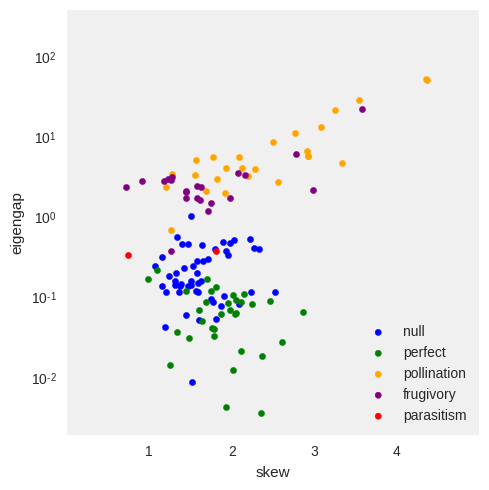

In [196]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = Studies[ Studies['type'] == ecology]
        ax = scatter( S['skew'], S['eigengap'], color=color, label=ecology )
        #for spectrum in S['spectrum'] :
        #    ax = plot( spectrum, color=color, label=ecology, linewidth=1 )

    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    xlim( [0,5] )
    xticks( [1,2,3,4] )
    ylim( [0.002,400] )

    
semilogy()
#ax.axes.legend(bbox_to_anchor=(0.9, 1.06), loc=7, borderaxespad=0., ncol=3)
legend( loc=4 )
tight_layout()

savefig( 'codiv_literature_skew_eigengap.pdf', dpi=100 )

...and let's how they cluster by spectral distance. Here, we take the 
distance matrix of pairwise Shanon-Jensen distances and apply some
hierarchical clustering.

In [55]:
distances = zeros( ( len(studies), len(studies) ) )

for i,I in enumerate(Studies.spectrum) :
    for j,J in enumerate(Studies.spectrum) :
        if i == j : continue
        #distances[i,j] = log(1+pdd( I, J ))
        distances[i,j] = pdd( I, J )
        
Distances = pd.DataFrame(distances, index=Studies.index, columns=Studies.index)

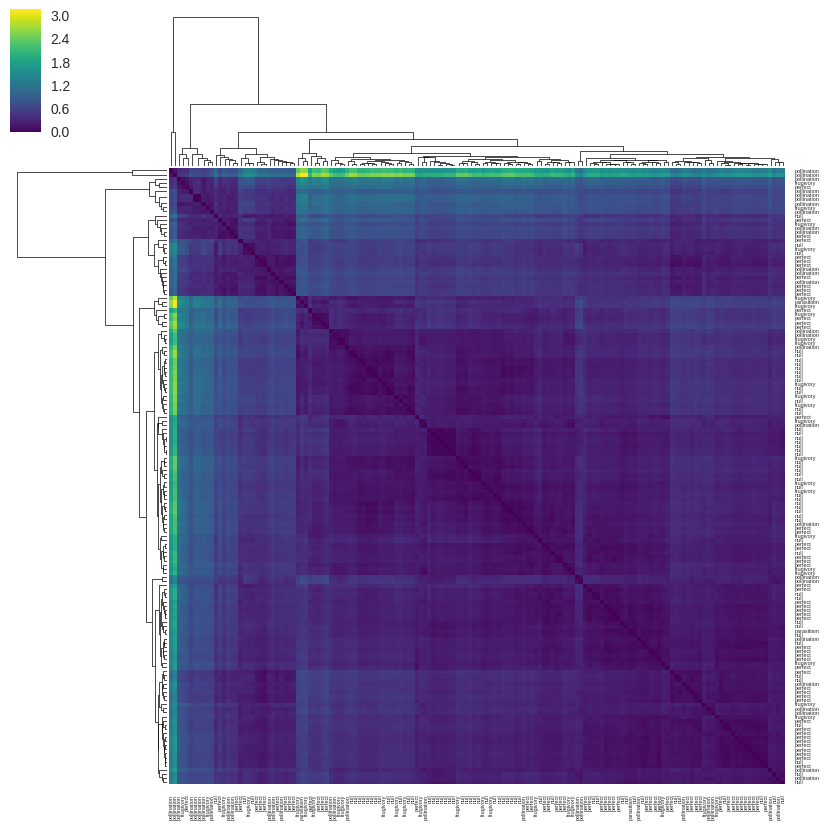

In [231]:
figure(figsize=(3,3))

studytypes = map( lambda x : x['type'], studies )
cm = seaborn.clustermap( Distances.as_matrix(), 
                         xticklabels=studytypes, 
                         yticklabels=studytypes, 
                         metric='euclidean', 
                         cmap='viridis' )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )

savefig( 'codiv_literature_clustermap.pdf', dpi=100 )

OK, we get some clustering by ecology, but nothing actually obvious.

Next, let's get our dataset of microbiome interactions loaded...

In [71]:
from SuchTree import SuchTree, SuchLinkedTrees
import pandas as pd

# checkpoint entry point

host_tree = SuchTree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
guest_tree = SuchTree( 'dissertation_run_unique_2_pruned.tree' )
links = pd.read_csv( 'dissertation_run_host_abundance_table_filtered.tsv', sep='\t', index_col=0 )

SLT = SuchLinkedTrees( host_tree, guest_tree, links )

...so that we can build the same feature space for all the subnetworks...

In [146]:
from pyprind import ProgBar
from scipy.stats import spearmanr, kendalltau, pearsonr

progbar = ProgBar( len(SLT.TreeB.get_internal_nodes()), monitor=True, title='Calculating spectral properties...' )

bandwidth=0.4

data = {}
dist_space = linspace( -0.5,1.5,200)
for n,nodeid in enumerate(SLT.TreeB.get_internal_nodes()) :
    #if n > 1000 : break
    SLT.subset_b( nodeid )
    progbar.update()
    if SLT.subset_b_size < 5 :
        continue
    if SLT.subset_n_links > 2500 :
        continue
    
    data[nodeid] = {}
    
    eg = SLT.spectrum()
    s = gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( dist_space )
    
    data[nodeid]['spectrum'] = s
    data[nodeid]['kurtosis'] = kurtosis(s)
    data[nodeid]['skew'] = skew(s)
    data[nodeid]['eigengap'] = eg[-1]-eg[-2]

    data[nodeid]['nlinks'] = SLT.subset_n_links
    d = SLT.linked_distances()
    r,p = pearsonr( d['TreeA'], d['TreeB'] )
    data[nodeid]['r'] = r
    data[nodeid]['p'] = p
    egA = eigvalsh( SLT.TreeA.laplacian()['laplacian'] )
    egB = eigvalsh( SLT.TreeB.laplacian( node=nodeid )['laplacian'] )
    
    spA = gaussian_kde( egA / max(egA), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    spB = gaussian_kde( egB / max(egB), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    
    data[nodeid]['treedist'] = pdd( spA, spB )
    data[nodeid]['occupancy'] = (2.0 * SLT.subset_n_links) / ( SLT.subset_a_size + SLT.subset_b_size )
    data[nodeid]['squareness'] = float( SLT.subset_a_size ) / SLT.subset_b_size

data = pd.DataFrame(data).T

Calculating spectral properties...
0%                          100%
[##############                ] | ETA: 02:15:14/home/russell/opt/local/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
[##############################] | ETA: 00:00:00
Total time elapsed: 03:20:57


In [185]:
#chechpoint exit
Data = data[['eigengap','kurtosis','skew','r','p','treedist','occupancy','squareness','nlinks']].applymap(float)
Data['spectrum'] = data['spectrum']
Data.to_csv( 'dissertation_spectral_properties.csv' )
Data.head()
#plot( data['occupancy'], data['nlinks'], 'ro' )

,eigengap,kurtosis,skew,r,p,treedist,occupancy,squareness,nlinks,spectrum
7,3.504506,2.964468,2.088225,-0.059626,3.693209e-07,0.211891,3.457143,0.250000,121.0,"[1.42454698169e-19, 8.09429784208e-19, 4.44105..."
15,2.227516,0.626871,1.383381,-0.256521,4.289082e-07,0.311511,2.333333,1.400000,28.0,"[8.44211571022e-09, 1.74425781584e-08, 3.55292..."
17,2.742398,0.740252,1.438733,-0.255810,3.830450e-05,0.326229,2.300000,2.333333,23.0,"[2.02639353917e-09, 4.39311755821e-09, 9.38175..."
25,2.776206,0.840125,1.484796,-0.209400,2.286347e-03,0.311608,2.210526,2.800000,21.0,"[1.79414281214e-09, 3.91312448426e-09, 8.40597..."
27,2.659138,2.478402,1.970074,-0.057410,4.883193e-06,0.210537,3.424242,0.269231,113.0,"[2.20139887903e-17, 1.02205924006e-16, 4.60088..."


In [54]:
# checkpoint entry
Data = pd.read_csv( 'dissertation_spectral_properties.csv', index_col=0 )

# reformat the array data back into actual arrays
Data['spectrum'] = Data['spectrum'].apply( lambda x : map( float, x.replace('[','').replace(']','').split() ) )

If we plot the microbiome data and the data from the literature along some
of their more informative axes, it looks like we might finally be getting
somewhere.

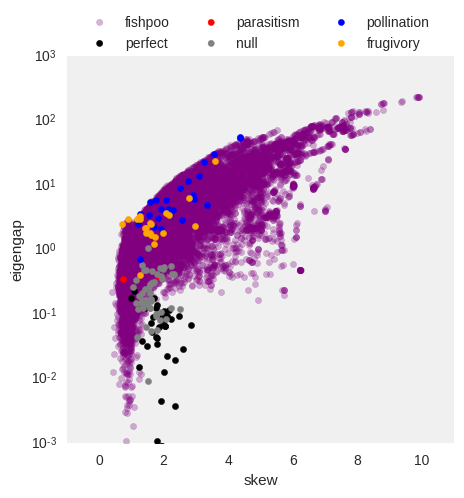

In [49]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'orange',
              'pollination' : 'blue' }

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    ax = scatter( Data['skew'], Data['eigengap'], 
                  color='purple', alpha=0.3, label='fishpoo' )
    
    for ecology, color in typecolor.iteritems() :
        S = Studies[ Studies['type'] == ecology]
        scatter( S['skew'], S['eigengap'], color=color, label=ecology )
        #for spectrum in S['spectrum'] :
        #    ax = plot( spectrum, color=color, label=ecology, linewidth=1 )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    xlim( [-1,11] )
    ylim( [10**-3,1000] )
    
    semilogy()
    ax.axes.legend(bbox_to_anchor=(0.95, 1.06), loc=7, borderaxespad=0., ncol=3)
    
    #tight_layout()

savefig( 'codiv_literature_fishpoo_skew_eigengap.png', dpi=300 )

Next, we calculate the Shanon-Jensen distances from each of the microbiome
subnetworks to the labeled networks.

In [72]:
from pyprind import ProgBar

progbar = ProgBar( Data.shape[0] * Studies.shape[0], 
                   monitor=True, title='Calculating spectral distnaces...' )

all_distances = zeros( ( Data.shape[0], Studies.shape[0] ) )

for n,(nodeid,sd) in enumerate( Data['spectrum'].iteritems() ) :
    for m,(studyname,ss) in enumerate( Studies['spectrum'].iteritems() ) :
        all_distances[ n, m ] = pdd( sd, ss )
        progbar.update()

Calculating spectral distnaces...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:06:31


In [74]:
# checkpoint exit

AD = pd.DataFrame(all_distances, index=Data.index, columns=Studies.index )
AD = AD.replace( numpy.inf, numpy.nan ).dropna()
AD.to_csv( 'dissertation_spectral_distances.csv', sep=',' )

In [53]:
import pandas as pd
# checkpoint entry

AD = pd.read_csv( 'dissertation_spectral_distances.csv.gz', sep=',', index_col=0 )

We can cluster these distances too, as long as we don't try to do *all* of them.

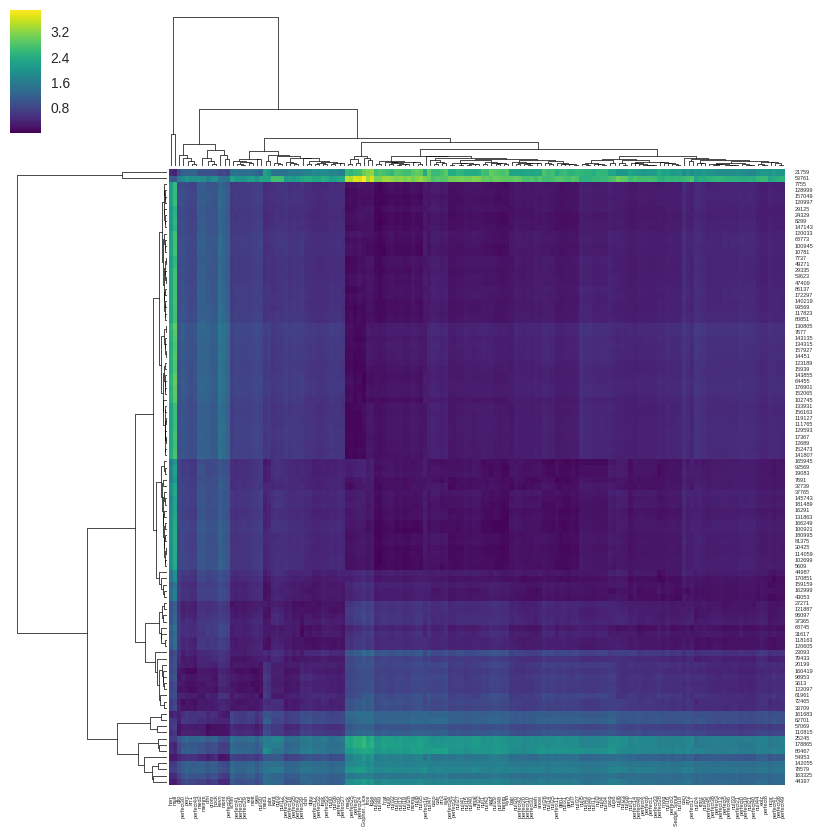

In [201]:
import seaborn

AD_sample = AD.sample(n=100)

cm = seaborn.clustermap( AD_sample.as_matrix(), 
                         xticklabels=AD_sample.columns, 
                         yticklabels=AD_sample.index, 
                         metric='euclidean', 
                         cmap='viridis' )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )

## Machine learning

We now have four pieces information. First, we have the spectral properties of each
our labled interactions where each interaction $G_{L,i}$ has a label $L_i$, forming 
a $(n \times 9)$ matrix :

$$
\psi = \begin{matrix}
G_{L,0} \cr
G_{L,1} \cr
G_{L,2} \cr
\vdots  \cr
G_{L,n} \cr 
\end{matrix}
\begin{bmatrix}
\lambda_{\delta,0} & \gamma_{1,0} & \gamma_{2,0} & r_{H,0} & p_{H,0} & D_{t,0} & k_{0}  & q_{0}  & n_{L,0} \cr
\lambda_{\delta,1} & \gamma_{1,1} & \gamma_{2,1} & r_{H,1} & p_{H,1} & D_{t,1} & k_{1}  & q_{1}  & n_{L,1} \cr
\lambda_{\delta,2} & \gamma_{1,2} & \gamma_{2,2} & r_{H,2} & p_{H,2} & D_{t,2} & k_{2}  & q_{2}  & n_{L,2} \cr
\vdots             & \vdots       & \vdots       & \vdots  & \vdots  & \vdots  & \vdots & \vdots & \vdots  \cr 
\lambda_{\delta,n} & \gamma_{1,n} & \gamma_{2,n} & r_{H,n} & p_{H,n} & D_{t,n} & k_{n}  & q_{n}  & n_{L,n} \cr
\end{bmatrix}
$$

We also have the Shanon-Jensen distance $D_{L,L,i,j}$ between each pair of labeled graphs

$$
D_{L,L,i,j} = D_{\rm SJ}( G_{L,i}, G_{L,j} )
$$

The pairwise distances yields an $(n\times n)$ symmetric distance matrix

$$
\xi_L =
\begin{bmatrix}
D_{L,L,0,0} & D_{L,L,0,1} & D_{L,L,0,2} & \cdots & D_{L,L,0,n} \cr
D_{L,L,1,0} & D_{L,L,1,1} & D_{L,L,1,2} & \cdots & D_{L,L,1,n} \cr
D_{L,L,2,0} & D_{L,L,2,1} & D_{L,L,2,2} & \cdots & D_{L,L,2,n} \cr
\vdots      & \vdots      & \vdots      & \ddots & \vdots      \cr
D_{L,L,n,0} & D_{L,L,n,1} & D_{L,L,n,2} & \cdots & D_{L,L,n,n} \cr
\end{bmatrix}
$$


These two matrixes have the same numer of columns, and can be pasted together to
form an $(n \times 9+n)$ feature space. We will use this space as the basis of
our system.

$$
\Psi_{L} = \left[ \psi_{L,(n \times 9)} | \xi_{L,(n \times n)} \right]
$$

The unlabled microbiome data that we would like to classify can be organized to
fit into the basis we just defined. The spectral properties of each subnetwork in
the microbiome forms an $(m \times 9)$ matrix :

$$
\psi_U =
\begin{matrix}
G_{U,0} \cr
G_{U,1} \cr
G_{U,2} \cr
\vdots  \cr
G_{U,n} \cr
\end{matrix}
\begin{bmatrix}
\lambda_{\delta,0} & \gamma_{1,0} & \gamma_{2,0} & r_{H,0} & p_{H,0} & D_{t,0} & k_{0}  & q_{0}  & n_{L,0} \cr
\lambda_{\delta,1} & \gamma_{1,1} & \gamma_{2,1} & r_{H,1} & p_{H,1} & D_{t,1} & k_{1}  & q_{1}  & n_{L,1} \cr
\lambda_{\delta,2} & \gamma_{1,2} & \gamma_{2,2} & r_{H,2} & p_{H,2} & D_{t,2} & k_{2}  & q_{2}  & n_{L,2} \cr
\vdots             & \vdots       & \vdots       & \vdots  & \vdots  & \vdots  & \vdots & \vdots & \vdots  \cr 
\lambda_{\delta,n} & \gamma_{1,n} & \gamma_{2,n} & r_{H,n} & p_{H,n} & D_{t,n} & k_{n}  & q_{n}  & n_{L,n} \cr
\end{bmatrix}
$$

We can then compute the Shanon-Jensen distance between each unlabled subnetwork
$G_{U,i}$ and each labled network $G_{L,j}$, forming an $(m \times n)$ matrix :

$$
\xi_U =
\begin{bmatrix}
D_{U,L,0,0} & D_{U,L,0,1} & D_{U,L,0,2} & \cdots & D_{U,L,0,n} \cr
D_{U,L,1,0} & D_{U,L,1,1} & D_{U,L,1,2} & \cdots & D_{U,L,1,n} \cr
D_{U,L,2,0} & D_{U,L,2,1} & D_{U,L,2,2} & \cdots & D_{U,L,2,n} \cr
\vdots      & \vdots      & \vdots      & \ddots & \vdots      \cr
D_{U,L,m,0} & D_{U,L,m,1} & D_{U,L,m,2} & \cdots & D_{U,L,m,n} \cr
\end{bmatrix}
$$

Together, we have $m$ unclassified objects with $n+9$ features organized into
an $(m \times n+9)$ matrix :

$$
\Psi_{U} = \left[ \psi_{U,(m \times 9)} | \xi_{U,(m \times n)} \right]
$$

Now, we're ready to go for machine learning. First, let's have a look at the
basis vectors.

Labled basis : [ 0.78523582  0.17888724  0.01392929  0.01029793  0.00342557]
Unlabled basis : [ 0.8734043   0.1134071   0.00554615  0.00474677  0.00109823]


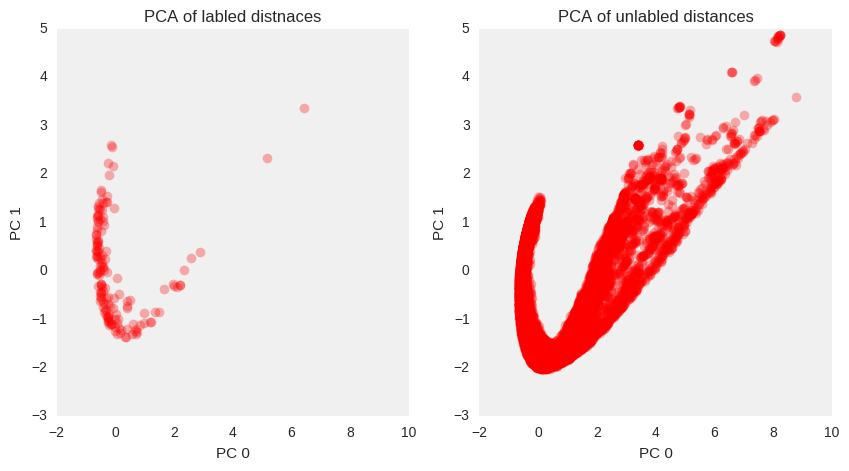

In [204]:
from sklearn.decomposition import PCA

figure(figsize=(10,5))

with seaborn.axes_style("white") :

    subplot(1,2,1,axisbg='#F0F0F0')

    pca = PCA( n_components=5, whiten=True )
    p = pca.fit( Distances )
    X = p.transform( Distances )
    print 'Labled basis :', p.explained_variance_ratio_

    ax = plot( X[:,0], X[:,1], 'ro', alpha=0.3 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    
    title( 'PCA of labled distnaces' )
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
    xlim( -2, 10 )
    ylim( -3, 5 )
    
    subplot(1,2,2,axisbg='#F0F0F0')
    
    pca = PCA( n_components=5, whiten=True )
    p = pca.fit( AD )
    X = p.transform( AD )
    print 'Unlabled basis :', p.explained_variance_ratio_
    
    ax = plot( X[:,0], X[:,1], 'ro', alpha=0.3 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)

    title( 'PCA of unlabled distances' )
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
    xlim( -2, 10 )
    ylim( -3, 5 )

Cool. It looks like 96% of the explained variance is in the first two
principle components, so we can look at 2D plots without sacrificing too
much information. Let's assemble our full feature spaces...

In [75]:
#AD.shape, Studies.shape, Data.shape
#Data.loc[ AD.index ].join( AD ).shape

X_data = Data[[ 'eigengap',
                'kurtosis',
                'skew',
                'r',
                'p',
                'treedist',
                'occupancy',
                'squareness',
                'nlinks']].loc[ AD.index ].join( AD ).dropna()

Y_data = Studies[[ 'eigengap',
                   'kurtosis',
                   'skew',
                   'r',
                   'p',
                   'treedist',
                   'occupancy',
                   'squareness',
                   'nlinks']].loc[ Distances.index ].join( Distances )

print 'Labled feagure table  :', Y_data.shape
print 'Unabled feature table :', X_data.shape
#Y_data

Labled feagure table  : (150, 159)
Unabled feature table : (36837, 159)


Labled basis : [  9.98772888e-01   1.02512092e-03   1.07541059e-04   4.35788654e-05
   2.33556042e-05]
Unlabled basis : [  9.98505357e-01   1.17805278e-03   1.63661077e-04   9.50705009e-05
   2.90744817e-05]


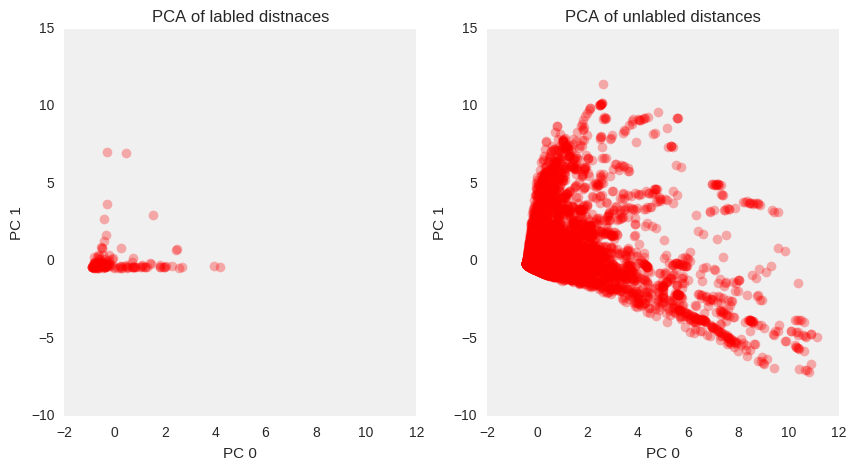

In [211]:
from sklearn.decomposition import PCA

figure(figsize=(10,5))

with seaborn.axes_style("white") :

    subplot(1,2,1,axisbg='#F0F0F0')

    pca = PCA( n_components=5, whiten=True )
    p = pca.fit( Y_data )
    X = p.transform( Y_data )
    print 'Labled basis :', p.explained_variance_ratio_

    ax = plot( X[:,0], X[:,1], 'ro', alpha=0.3 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    
    title( 'PCA of labled distnaces' )
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
    xlim( -2, 12 )
    ylim( -10, 15 )    
    
    subplot(1,2,2,axisbg='#F0F0F0')
    
    pca = PCA( n_components=5, whiten=True )
    p = pca.fit( X_data )
    X = p.transform( X_data )
    print 'Unlabled basis :', p.explained_variance_ratio_
    
    ax = plot( X[:,0], X[:,1], 'ro', alpha=0.3 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)

    title( 'PCA of unlabled distances' )
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
    xlim( -2, 12 )
    ylim( -10, 15 )

Great! 99.8% of the variance is explained in the first two components. Let's see
what it looks like when we project the unlabled data into a space spanned by the
labled data...

[  9.98772888e-01   1.02512092e-03   1.07541059e-04   4.35788654e-05
   2.33556042e-05   1.66996905e-05   3.41265165e-06   2.53040574e-06
   1.51519348e-06   9.80335881e-07   6.32781885e-07   4.96544175e-07
   3.66836422e-07   1.90448956e-07   1.28063915e-07   8.99501640e-08
   6.62933779e-08   6.20368449e-08   4.95995733e-08   3.63866398e-08
   3.05339031e-08   2.61108318e-08   1.74593470e-08   1.31483748e-08
   1.21588950e-08   1.05320323e-08   1.01943347e-08   7.69086847e-09
   7.22440185e-09   6.31151351e-09   6.10684429e-09   5.82302737e-09
   5.70047073e-09   4.73679218e-09   4.41132970e-09   4.14202343e-09
   3.72861070e-09   3.58427891e-09   3.21740700e-09   3.08735100e-09
   2.84004970e-09   2.68352375e-09   2.55008165e-09   2.37876413e-09
   2.29102344e-09   2.12048872e-09   2.03924392e-09   1.92476976e-09
   1.74887081e-09   1.62389614e-09   1.54127447e-09   1.52091137e-09
   1.50081569e-09   1.44577390e-09   1.38992259e-09   1.30328626e-09
   1.26203137e-09   1.21744660e-09

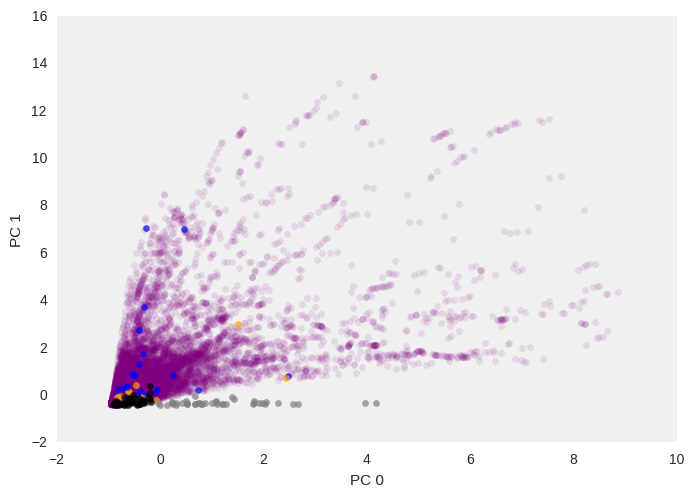

In [82]:
from sklearn.decomposition import PCA

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'orange',
              'pollination' : 'blue' }

pca = PCA( n_components=150, whiten=True )
p = pca.fit( Y_data )
X = p.transform( X_data )
Y = p.transform( Y_data )
print p.explained_variance_ratio_

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    ax = scatter( X[:,0], X[:,1], color='purple', alpha=0.1, label='fishpoo' )
    
    for st,x,y in zip( Studies['type'], Y[:,0], Y[:,1] ) :
        ax = scatter( [x], [y], color=typecolor[st], alpha=0.7, label=st )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
    #loglog()
#legend()

OK! Let's train some classifiers. `scikit-learn` makes it really easy
to try out several different classifiers with their standardized interface.
It looks like the neural network classifier gives us the best decision boundary
for this problem, but we don't have enough training data to test and 
optimize the classifier tuning parameters.

In [186]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

#classifier = KNeighborsClassifier(3, metric='euclidean')
#classifier = SVC(kernel="linear", C=0.025)
#classifier = SVC(gamma=2, C=1)
#classifier = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
#classifier = DecisionTreeClassifier(max_depth=5)
#classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=3)
#classifier = AdaBoostClassifier()
#classifier = GaussianNB()
#classifier = QuadraticDiscriminantAnalysis()
classifier = MLPClassifier(alpha=1, max_iter=10000, learning_rate_init=0.0001)

classifier.fit( Y_data, Studies['type'] )

predictions = classifier.predict( X_data )

In [187]:
classifier

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.0001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

We've only got 150 samples to train on, so we can't really do a proer
job of testing how well the classifer performs. That also means we can't
systematically optimize the tuning parameters. But, we can at least look
at how often the classifier correctly predicts the lablel for our labled
data.

In [188]:
print 'Accuracy :', sum( map( lambda x : x[0] == x[1], 
                              zip( classifier.predict( Y_data ), Studies['type'] ) ) ) \
                    / float(Studies.shape[0])

Accuracy : 0.973333333333


That's pretty good! If you re-train the classifier, there is some stochastic 
variance in the accuracy, but it seems to stay around 97-98%. 

So, that's pretty much it. We've got our predicted ecological labels for the
subnetworks in the microbiome data. Let's visualize the training data and the
predictions, and we're done.

In [119]:
YY = pd.DataFrame(Y, columns=[ 'PC%d' % i for i in range(150) ], index=Y_data.index)
YY['type'] = Studies['type']

Predictions = pd.DataFrame(predictions, columns=['type'], index=X_data.index)
Projecton = pd.DataFrame(X, columns=[ 'PC%d' % i for i in range(150) ], index=X_data.index)
PP = Predictions.join( Projecton )
PP.head()

,type,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149
7,pollination,-0.484079,0.202313,0.267204,-0.093500,1.389365,0.257761,-3.612245,1.104806,-0.583274,...,-0.312076,0.439265,0.940872,1.217122,-1.482219,1.584167,0.901036,-0.574299,-1.904936e+11,-1.634948e+12
15,frugivory,-0.852390,-0.167048,-0.903913,0.176630,-0.341664,-0.292608,-0.325606,-1.488918,-0.118908,...,-0.106554,0.250105,-0.272313,0.507640,0.059650,1.262332,0.195496,-0.188115,-1.633816e+11,-1.272961e+10
17,frugivory,-0.872191,-0.087014,-0.786315,0.634185,-0.615156,-0.698231,-1.051516,-1.530916,-0.592749,...,-0.099744,0.095445,-0.382495,0.355073,-0.048410,1.775807,0.143450,-1.051863,-1.850857e+11,-2.521885e+11
25,frugivory,-0.880113,-0.078578,-0.699969,0.827643,-0.764903,-0.989085,-1.067132,-1.397287,-0.566602,...,-0.101990,-0.023838,-0.454411,0.362419,0.009508,1.663417,0.109219,-0.892139,-1.834410e+11,-1.446171e+11
27,pollination,-0.515760,0.062755,0.148365,-0.115692,1.336700,0.074102,-3.342430,0.935892,-0.575049,...,-0.443801,0.220639,1.034115,1.184215,-1.197793,0.997165,0.841114,-0.451937,-2.068890e+11,-1.287541e+12


Here is the labeled training data and the predictions projected into
a space spanned by the first and second principle components of the
training data.

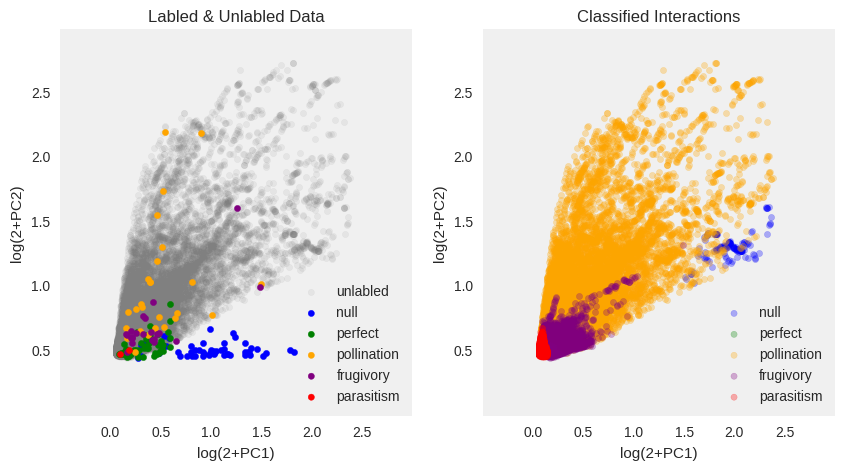

In [141]:
figure(figsize=(10,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

with seaborn.axes_style("white") :

    subplot(1,2,1,axisbg='#F0F0F0')

    title( 'Labled & Unlabled Data' )
        
    ax = scatter( log(2+PP['PC0']), log(2+PP['PC1']), 
                  color='gray', alpha=0.1, label='unlabled' )
    
    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = YY[ Studies['type'] == ecology]
        scatter( log(2+S['PC0']), log(2+S['PC1']), color=color, label=ecology )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'log(2+PC1)' )
    ylabel( 'log(2+PC2)' )
    xticks( [0,0.5,1,1.5,2,2.5] )
    yticks( [0.5,1,1.5,2,2.5] )
    
    legend(loc=4)
    
    subplot(1,2,2,axisbg='#F0F0F0')

    title( 'Classified Interactions' )
    
    for st in ['null','perfect','pollination','frugivory','parasitism'] :
        pp = PP[ PP['type'] == st ] 
        ax = scatter( log(2+pp['PC0']), log(2+pp['PC1']), color=typecolor[st], alpha=0.3, label=st )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'log(2+PC1)' )
    ylabel( 'log(2+PC2)' )
    xticks( [0,0.5,1,1.5,2,2.5] )
    yticks( [0.5,1,1.5,2,2.5] )
    
    legend(loc=4)
    
savefig( 'codiv_literature_fishpoo_classified_PCA.png', dpi=300 )

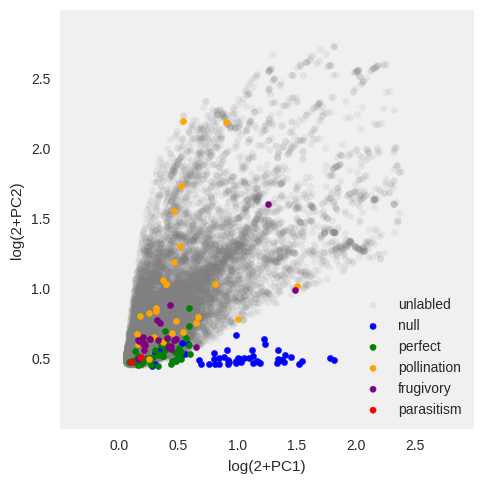

In [147]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    #title( 'Labled & Unlabled Data' )
        
    ax = scatter( log(2+PP['PC0']), log(2+PP['PC1']), 
                  color='gray', alpha=0.1, label='unlabled' )
    
    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = YY[ Studies['type'] == ecology]
        scatter( log(2+S['PC0']), log(2+S['PC1']), color=color, label=ecology )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'log(2+PC1)' )
    ylabel( 'log(2+PC2)' )
    xticks( [0,0.5,1,1.5,2,2.5] )
    yticks( [0.5,1,1.5,2,2.5] )

    legend(loc=4)
    
    tight_layout()
    
savefig( 'codiv_literature_fishpoo_classified_PCA_a.png', dpi=300 )

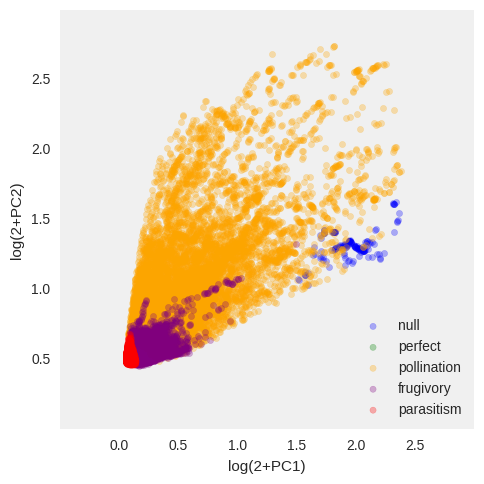

In [148]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

with seaborn.axes_style("white") :
    
    subplot(axisbg='#F0F0F0')

    #title( 'Classified Interactions' )
    
    for st in ['null','perfect','pollination','frugivory','parasitism'] :
        pp = PP[ PP['type'] == st ] 
        ax = scatter( log(2+pp['PC0']), log(2+pp['PC1']), color=typecolor[st], alpha=0.3, label=st )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'log(2+PC1)' )
    ylabel( 'log(2+PC2)' )
    xticks( [0,0.5,1,1.5,2,2.5] )
    yticks( [0.5,1,1.5,2,2.5] )

    legend(loc=4)
    
    tight_layout()
    
savefig( 'codiv_literature_fishpoo_classified_PCA_b.png', dpi=300 )

Here is the labeled training data and the predictions projected into
a space spanned by the two important axes.

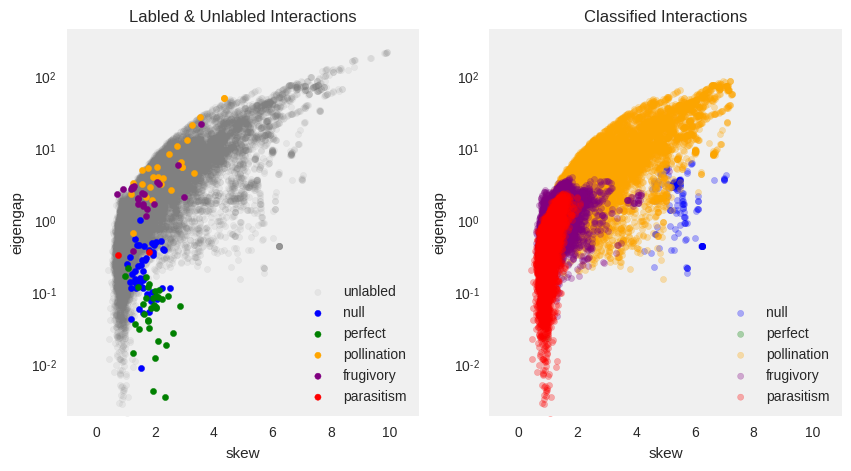

In [128]:
figure(figsize=(10,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

X_predictions = X_data.join(Predictions)

with seaborn.axes_style("white") :
    
    subplot(1,2,1,axisbg='#F0F0F0')
    title( 'Labled & Unlabled Interactions' )
    
    ax = scatter( Data['skew'], Data['eigengap'], 
                  color='gray', alpha=0.1, label='unlabled' )
    
    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = Studies[ Studies['type'] == ecology]
        scatter( S['skew'], S['eigengap'], color=color, label=ecology )
        #for spectrum in S['spectrum'] :
        #    ax = plot( spectrum, color=color, label=ecology, linewidth=1 )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    xlim( [-1,11] )
    ylim( [0.002,500] )
    
    semilogy()
    #ax.axes.legend(bbox_to_anchor=(0.95, 1.06), loc=7, borderaxespad=0., ncol=3)
    legend(loc=4)
    
    subplot(1,2,2,axisbg='#F0F0F0')
    title( 'Classified Interactions' )

    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = X_predictions[ X_predictions['type'] == ecology]
        ax = scatter( S['skew'], S['eigengap'], color=color, alpha=0.3, label=ecology )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    xlim( [-1,11] )
    ylim( [0.002,500] )
    
    semilogy()
    #ax.axes.legend(bbox_to_anchor=(0.95, 1.06), loc=7, borderaxespad=0., ncol=3)
    legend(loc=4)
    
    #tight_layout()

savefig( 'codiv_literature_fishpoo_classified_skew_eigengap.png', dpi=300 )

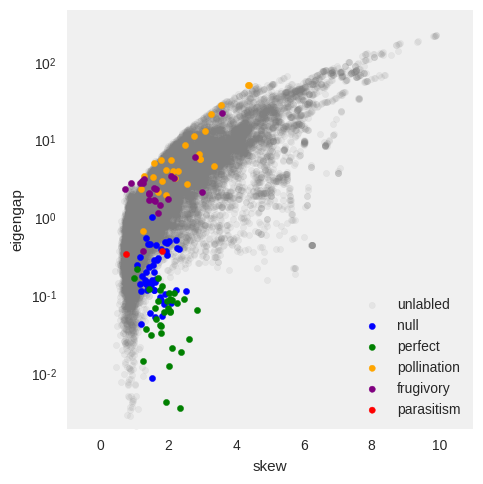

In [149]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

X_predictions = X_data.join(Predictions)

with seaborn.axes_style("white") :
    
    subplot(axisbg='#F0F0F0')
    #title( 'Labled & Unlabled Data' )
    
    ax = scatter( Data['skew'], Data['eigengap'], 
                  color='gray', alpha=0.1, label='unlabled' )
    
    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = Studies[ Studies['type'] == ecology]
        scatter( S['skew'], S['eigengap'], color=color, label=ecology )
        #for spectrum in S['spectrum'] :
        #    ax = plot( spectrum, color=color, label=ecology, linewidth=1 )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    xlim( [-1,11] )
    ylim( [0.002,500] )
    
    semilogy()
    #ax.axes.legend(bbox_to_anchor=(0.95, 1.06), loc=7, borderaxespad=0., ncol=3)
    legend(loc=4)
    
    tight_layout()

savefig( 'codiv_literature_fishpoo_classified_skew_eigengap_a.png', dpi=300 )

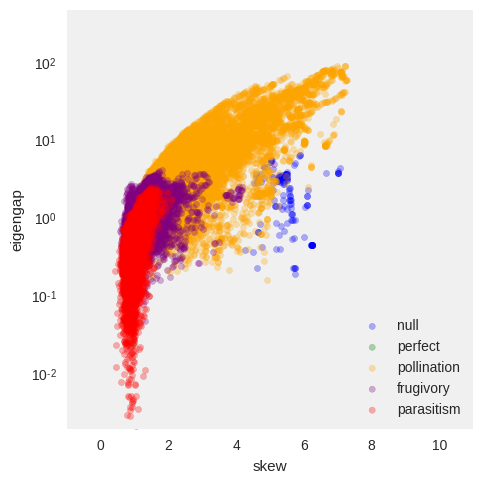

In [150]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'blue', 
              'perfect'     : 'green',
              'parasitism'  : 'red',
              'frugivory'   : 'purple',
              'pollination' : 'orange' }

X_predictions = X_data.join(Predictions)

with seaborn.axes_style("white") :
    
    subplot(axisbg='#F0F0F0')
    #title( 'Classified Data' )

    for ecology in ['null','perfect','pollination','frugivory','parasitism'] :
        color = typecolor[ecology]
        S = X_predictions[ X_predictions['type'] == ecology]
        ax = scatter( S['skew'], S['eigengap'], color=color, alpha=0.3, label=ecology )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    xlim( [-1,11] )
    ylim( [0.002,500] )
    
    semilogy()
    #ax.axes.legend(bbox_to_anchor=(0.95, 1.06), loc=7, borderaxespad=0., ncol=3)
    legend(loc=4)
    
    tight_layout()

savefig( 'codiv_literature_fishpoo_classified_skew_eigengap_b.png', dpi=300 )

Journals vary in how they want figures submitted for production so I've
included combined and individual plots, and some code to help format a 
LaTeX table of spectral properties for the training data. 

In [48]:
print 'name, label, nlinks, occupancy, squareness, eigengap, kurtosis, skew, r, p, treedist'
for i,row in Studies[:50].iterrows() :
    print i, '&', \
          row['type'], '&', \
          row['nlinks'], '&', \
          '%.2f' % row['occupancy'], '&', \
          '%.2f' % row['squareness'], '&', \
          '%.2f' % row['eigengap'], '&', \
          '%.2f' % row['kurtosis'], '&', \
          '%.2f' % row['skew'], '&', \
          '%.3f' % row['r'], '&', \
          '%.1e' % row['p'], '&', \
          '%.2f' % row['treedist'], '\\\\'

name, label, nlinks, occupancy, squareness, eigengap, kurtosis, skew, r, p, treedist
Gopher, Lice & parasitism & 17 & 1.06 & 0.88 & 0.36 & -0.70 & 0.74 & 0.490 & 1.4e-09 & 0.14 \\
Sedge, Smut & parasitism & 41 & 1.24 & 1.44 & 0.39 & 1.99 & 1.81 & 0.152 & 1.3e-05 & 0.18 \\
beeh & frugivory & 119 & 5.95 & 3.44 & 1.81 & 1.07 & 1.58 & -0.036 & 2.4e-03 & 0.11 \\
arr1 & pollination & 307 & 3.41 & 0.88 & 7.06 & 7.52 & 2.91 & 0.045 & 4.2e-22 & 0.09 \\
arr2 & pollination & 170 & 3.33 & 0.73 & 3.12 & 1.88 & 1.83 & 0.054 & 8.3e-11 & 0.06 \\
arr3 & pollination & 62 & 2.14 & 1.64 & 0.72 & 0.02 & 1.27 & 0.091 & 7.6e-05 & 0.09 \\
bair & frugivory & 50 & 3.57 & 0.33 & 1.23 & 1.67 & 1.71 & -0.032 & 2.6e-01 & 0.47 \\
cacg & frugivory & 65 & 3.42 & 1.53 & 2.49 & 1.09 & 1.63 & -0.019 & 3.8e-01 & 0.11 \\
caco & frugivory & 47 & 2.61 & 1.77 & 2.19 & 0.52 & 1.44 & -0.009 & 7.6e-01 & 0.09 \\
caci & frugivory & 94 & 3.55 & 1.65 & 3.68 & 2.90 & 2.08 & -0.047 & 1.9e-03 & 0.03 \\
cafr & frugivory & 51 & 2.83 & 1.